In [18]:
from Bio import SeqIO
from operator import itemgetter
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.figure import Figure
import io

In [6]:
cd /Users/davidchen/Desktop/Mutation_signature/S


/Users/davidchen/Desktop/Mutation_signature/S


# Split single fasta into one fasta per sequence

In [3]:
fasta_sequences = SeqIO.parse(open("Mutation_signature/SARS-COV-2.fasta"),'fasta')

counter = 0
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    filtered_name = name.replace("/","_")
    with open("/Users/davidchen/Desktop/Sequence/" + filtered_name + ".fasta", "w+") as handle:
         SeqIO.write(fasta, handle,"fasta")

    counter += 1
print(counter)
            

FileNotFoundError: [Errno 2] No such file or directory: 'Mutation_signature/SARS-COV-2.fasta'

# 1. Multiple Alignment using Fast Fourier Transform (MAFFT)

mafft --reorder --anysymbol --add new_sequences --auto input 

# 2. SNP-Sites

snp-sites -v -c -o gisaid_hcov-19_L_snps.vcf gisaid_hcov-19_L_aln.fasta


# 3. Extract signature from VCF

In [4]:
import vcf

# Helper function to split one multi-seq fasta into smaller equal size chunks


In [413]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

chunk_number = 2
records = list(SeqIO.parse("/Users/davidchen/Desktop/Mutation_signature/GR/gisaid_hcov-19_GR.fasta", "fasta"))
chunk_size = sum(len(r) for r in records) // chunk_number + 1


def create_batch(records, chunk_size):
    record_it = iter(records)

    record = next(record_it)
    current_base = 0

    batch = []
    batch_size = 0

    # While there are new records, keep creating new batches.
    while record:
        # Loop over records untill the batch is full. (or no new records)
        while batch_size != chunk_size and record:

            end = current_base + chunk_size - batch_size
            seq = record[current_base:end]

            end_of_slice = current_base + len(seq) - 1
            fasta_header = record.id + ":{}-{}".format(current_base, end_of_slice)

            seq.id = seq.name = fasta_header
            seq.description = ''
            batch.append(seq)

            current_base += len(seq)
            batch_size += len(seq)

            # Current record is exhausted, get a new one.
            if current_base >= len(record):
                record = next(record_it, None)
                current_base = 0

        # We have a batch with the correct size (or no new bathces)
        yield batch
        batch = []
        batch_size = 0


for i, batch in enumerate(create_batch(records, chunk_size)):
    filename = "/Users/davidchen/Desktop/Mutation_signature/GR/" + "chunk{}.fasta".format(i)
    SeqIO.write(batch, filename, "fasta")

# Helper function to expand a dataframe

In [8]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

# Read a VCF as a Pandas dataframe


In [115]:
def read_vcf(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

In [117]:
def filter_vcf(month, year, clade, aaf_limit):
    
    vcf_reader = vcf.Reader(open("/Users/davidchen/Desktop/Mutation_signature/" + str(clade) + "/" + str(clade) + "_" + str(month) + "_" + str(year) + "_snps.vcf", 'r'))
  
    total = []
    position = []
    ref = []
    alt = []
    
    for record in vcf_reader:
        total.append(record.POS)
        if aaf_limit > 0:
            if record.aaf[0] > aaf_limit:
                position.append(record.POS)
                ref.append(record.REF)
                alt.append(record.ALT)
            else:
                pass
        else:
            position.append(record.POS)
            ref.append(record.REF)
            alt.append(record.ALT)
    
    if aaf_limit > 0:
        print()
        data = pd.DataFrame(columns=["position", "reference", "alternate"])
        data["position"] = position
        data["reference"] = ref
        data["alternate"] = alt
    else:
        data = pd.DataFrame(columns=["total", "reference", "alternate"])
        data["total"] = position
        data["reference"] = ref
        data["alternate"] = alt
        
    return data

# Plotting function

In [85]:
def sig_table(month, year, clade, base_type, aaf_limit=0):
    
    reference =  str(next(SeqIO.parse("/Users/davidchen/Desktop/Mutation_signature/" + str(clade) + "/" + str(clade) + "_" + str(month) + "_" + str(year) + "_aln.fasta", "fasta")).seq).upper()
    vcf_reader = vcf.Reader(open("/Users/davidchen/Desktop/Mutation_signature/" + str(clade) + "/" + str(clade) + "_" + str(month) + "_" + str(year) + "_snps.vcf", 'r'))
  
    total = []
    position = []
    ref = []
    alt = []
    
    for record in vcf_reader:
        total.append(record.POS)
        if aaf_limit > 0:
            if record.aaf[0] > aaf_limit:
                position.append(record.POS)
                ref.append(record.REF)
                alt.append(record.ALT)
            else:
                pass
        else:
            position.append(record.POS)
            ref.append(record.REF)
            alt.append(record.ALT)
    
   
    print(str(len(position)) + " alternate SNPs included out of a total of " + str(len(total)) + " SNPs" )
    
    counter = 0
    for i in range(len(ref)):
        if ref[i] == reference[position[i] - 1]:
            pass
        else: 
            counter += 1
    print(str(counter) + ' identified SNPs do not match reference base!')
    
    
    snps = pd.DataFrame(index = range(len(position)), columns=['position', 'reference', 'alternate'])
    snps['position'] = position
    snps['reference'] = ref
    snps['alternate'] = alt
    
    snps_expand = explode(snps, ["alternate"])
    
    sbs_96 = pd.read_excel("/Users/davidchen/Documents/GitHub/SomaticSiMu/Reference/WGS_PCAWG.96.xlsx")
    classification = sbs_96.iloc[:, :2]
    classification['Frequency'] = 0
    
    if base_type == 'purine':
        for row in range(len(classification)):
            mut_type = classification.loc[row, 'Mutation type']
            if mut_type[0] == "C":
                classification.loc[row, 'Mutation type'] = "G" + str(mut_type[1:])   
            if mut_type[0] == "T":
                classification.loc[row, 'Mutation type'] = "A" + str(mut_type[1:])
            if classification.loc[row, 'Mutation type'][0] == "G" and classification.loc[row, 'Mutation type'][-1] == "G":
                classification.loc[row, 'Mutation type'] = classification.loc[row, 'Mutation type'][:2] + "C"
            if classification.loc[row, 'Mutation type'][0] == "A" and classification.loc[row, 'Mutation type'][-1] == "A":
                classification.loc[row, 'Mutation type'] = classification.loc[row, 'Mutation type'][:2] + "T"


            trinuc = classification.loc[row, 'Trinucleotide']

            if mut_type[0] == "C":
                classification.loc[row, 'Trinucleotide'] = str(trinuc[0]) + "G" + str(trinuc[-1])
            if mut_type[0] == "T":
                classification.loc[row, 'Trinucleotide'] = str(trinuc[0]) + "A" + str(trinuc[-1])

    for i in range(len(snps_expand)):

        #position on ref seq
        position = snps_expand.loc[i, "position"] -1
        #trinuc context on ref seq
        trinuc_context = str(reference[position-1:position+2])

        #SBS classification
        mutation_type = str(snps_expand.loc[i, "reference"]) + ">" + str(snps_expand.loc[i, "alternate"])

        trinuc_filter = classification[classification['Trinucleotide'] == trinuc_context] 
        row_index = trinuc_filter[trinuc_filter['Mutation type'] == mutation_type].index

        classification.loc[row_index, 'Frequency'] += 1

    print(str(classification['Frequency'].sum()) + " total SNPs sorted into SBS-192 classification scheme")

    #classification['Frequency'] = classification['Frequency'].div(classification['Frequency'].sum())
    #classification['Frequency'] = classification['Frequency'].multiply(100)
    #classification.sort_values(by=["Mutation type","Trinucleotide"],inplace=True )
    
    return classification
    

In [86]:
def sig_plot(classification, base_type):

    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    N = 96
    ind = np.arange(96)   

    color_list = [(0.416, 0.733, 0.918), (0,0,0), (0.765, 0.172, 0.157), (0.785, 0.785, 0.785), (0.678, 0.808, 0.412), (0.878, 0.773, 0.769)]

    p1 = ax.bar(range(0,16), classification.iloc[0:16, 2], bottom=0, color = color_list[0])
    p2 = ax.bar(range(16,32), classification.iloc[16:32, 2], bottom=0, color = color_list[1])
    p3 = ax.bar(range(32,48), classification.iloc[32:48, 2], bottom=0, color = color_list[2])
    p4 = ax.bar(range(48,64), classification.iloc[48:64, 2], bottom=0, color = color_list[3])
    p5 = ax.bar(range(64,80), classification.iloc[64:80, 2], bottom=0, color = color_list[4])
    p6 = ax.bar(range(80,96), classification.iloc[80:96, 2], bottom=0, color = color_list[5])

    y_limit = ax.get_ylim()[1]

    rect1 = patches.Rectangle((0, y_limit + y_limit/50), 15, y_limit/20, color = color_list[0], clip_on=False) 
    rect2 = patches.Rectangle((16, y_limit + y_limit/50), 15, y_limit/20, color = color_list[1], clip_on=False) 
    rect3 = patches.Rectangle((32, y_limit + y_limit/50), 15, y_limit/20, color = color_list[2], clip_on=False) 
    rect4 = patches.Rectangle((48, y_limit + y_limit/50), 15, y_limit/20, color = color_list[3], clip_on=False) 
    rect5 = patches.Rectangle((64, y_limit + y_limit/50), 15, y_limit/20, color = color_list[4], clip_on=False) 
    rect6 = patches.Rectangle((80, y_limit + y_limit/50), 15, y_limit/20, color = color_list[5], clip_on=False) 

    if base_type == 'pyrimidine':
        plt.text(7, y_limit + y_limit/9, "C>A", fontsize=12, weight="bold")
        plt.text(23, y_limit + y_limit/9, "C>G", fontsize=12, weight="bold")
        plt.text(39, y_limit + y_limit/9, "C>T", fontsize=12, weight="bold")
        plt.text(55, y_limit + y_limit/9, "T>A", fontsize=12, weight="bold")
        plt.text(71, y_limit + y_limit/9, "T>C", fontsize=12, weight="bold")
        plt.text(87, y_limit + y_limit/9, "T>G", fontsize=12, weight="bold")
    if base_type == 'purine':
        plt.text(7, y_limit + y_limit/9, "G>A", fontsize=12, weight="bold")
        plt.text(23, y_limit + y_limit/9, "G>C", fontsize=12, weight="bold")
        plt.text(39, y_limit + y_limit/9, "G>T", fontsize=12, weight="bold")
        plt.text(55, y_limit + y_limit/9, "A>T", fontsize=12, weight="bold")
        plt.text(71, y_limit + y_limit/9, "A>C", fontsize=12, weight="bold")
        plt.text(87, y_limit + y_limit/9, "A>G", fontsize=12, weight="bold")

    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    ax.add_patch(rect4)
    ax.add_patch(rect5)
    ax.add_patch(rect6)

    ax.set_xlabel('SubType', fontsize=15, weight="bold")
    ax.yaxis.set_label_text('Count of Single Base Substitutions', fontsize=15, weight="bold")

    ax.set_xticks(ind)
    ax.set_xticklabels(classification['Trinucleotide'], fontsize=6)

    plt.xticks(rotation=90)
    ax.margins(x=0)
    ax.set_title(" ", pad=140)

    ax.grid(axis = 'y', color=color_list[3], linestyle='-', linewidth = 1)
    ax.set_axisbelow(True)
    ax.xaxis.labelpad= 10
    ax.yaxis.labelpad= 10

# Clade S: January 2020

12 alternate SNPs included out of a total of 12 SNPs
0 identified SNPs do not match reference base!
4 total SNPs sorted into SBS-192 classification scheme
12 alternate SNPs included out of a total of 12 SNPs
0 identified SNPs do not match reference base!
8 total SNPs sorted into SBS-192 classification scheme


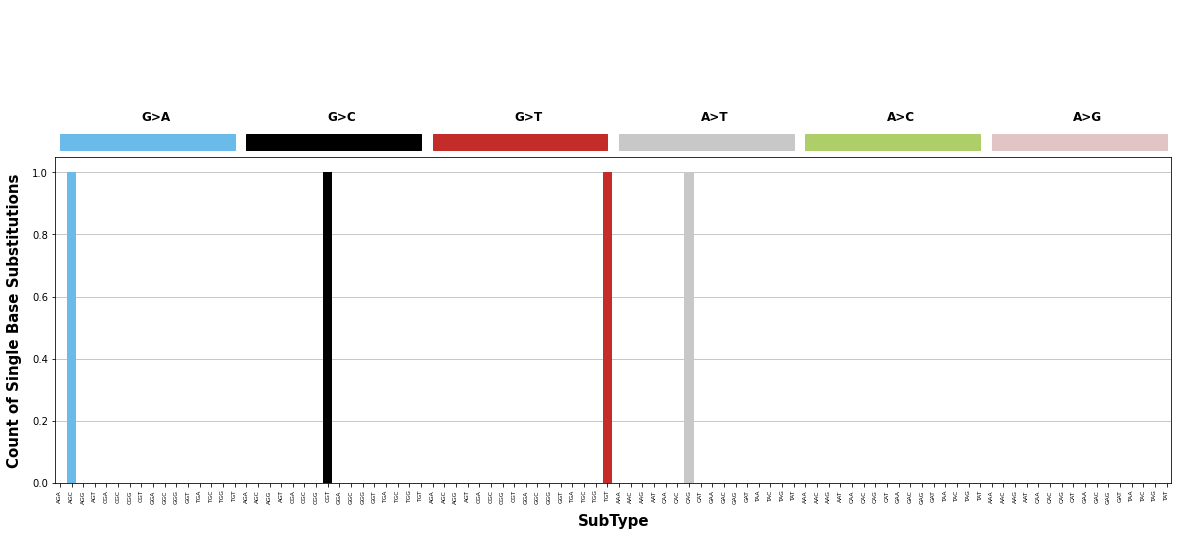

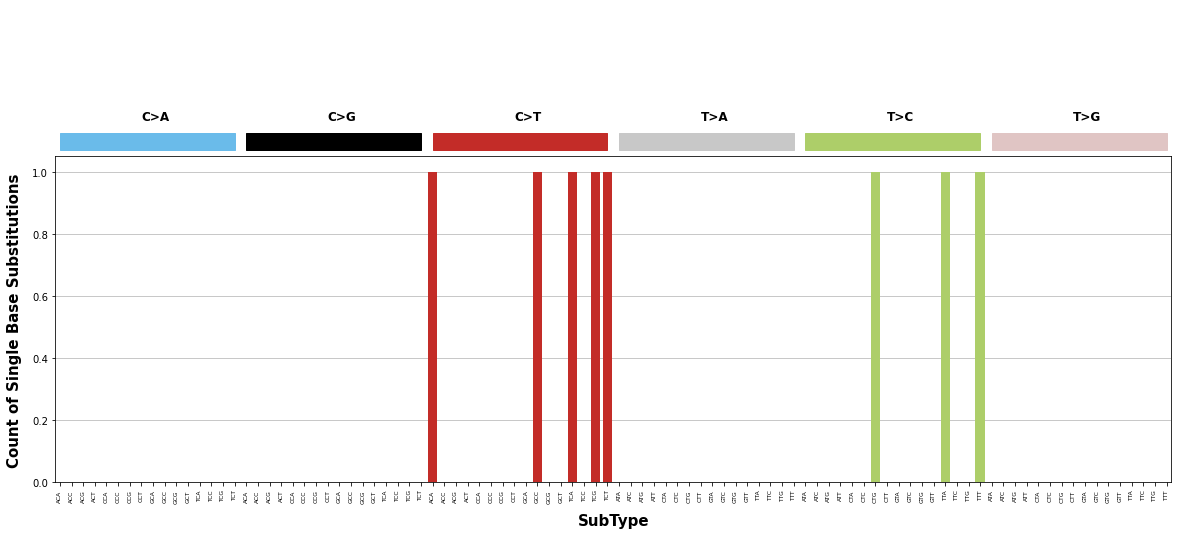

In [98]:
s_purine_01_2020 = sig_table(month="01", year="2020", clade= "S", base_type = "purine", aaf_limit=0.05)
sig_plot(s_purine_01_2020, base_type = "purine")
s_pyrimidine_01_2020 = sig_table(month="01", year="2020", clade= "S", base_type = "pyrimidine", aaf_limit=0.05)
sig_plot(s_pyrimidine_01_2020, base_type = "pyrimidine")

In [88]:
df_S_01_2020 = read_vcf("S_01_2020_snps.vcf")
df_S_01_2020

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NC_045512.2,hCoV-19/Shenzhen/SZTH-002/2020|EPI_ISL_406593|2020-01-13,hCoV-19/USA/AZ1/2020|EPI_ISL_406223|2020-01-22,hCoV-19/Guangdong/20SF012/2020|EPI_ISL_403932|2020-01-14,hCoV-19/Guangdong/20SF013/2020|EPI_ISL_403933|2020-01-15,hCoV-19/Guangdong/20SF025/2020|EPI_ISL_403935|2020-01-15,hCoV-19/Shenzhen/HKU-SZ-005/2020|EPI_ISL_405839|2020-01-11,hCoV-19/Shenzhen/HKU-SZ-002/2020|EPI_ISL_406030|2020-01-10,hCoV-19/USA/CA1/2020|EPI_ISL_406034|2020-01-23,hCoV-19/Wuhan/WH04/2020|EPI_ISL_406801|2020-01-05,hCoV-19/USA/WA1/2020|EPI_ISL_404895|2020-01-19
0,1,1548,.,G,A,.,.,.,GT,0,0,0,0,0,0,0,0,1,0,0
1,1,8782,.,C,T,.,.,.,GT,0,1,1,1,1,1,1,1,1,1,1
2,1,9561,.,C,T,.,.,.,GT,0,0,0,0,0,0,1,0,0,0,0
3,1,11083,.,G,T,.,.,.,GT,0,0,1,0,0,0,0,0,0,0,0
4,1,15607,.,T,C,.,.,.,GT,0,0,0,0,0,0,1,0,0,0,0
5,1,18060,.,C,T,.,.,.,GT,0,0,0,0,0,0,0,0,0,0,1
6,1,24034,.,C,T,.,.,.,GT,0,0,0,0,0,0,0,0,1,0,0
7,1,26729,.,T,C,.,.,.,GT,0,0,0,0,0,0,0,0,1,0,0
8,1,28077,.,G,C,.,.,.,GT,0,0,0,0,0,0,0,0,1,0,0
9,1,28144,.,T,C,.,.,.,GT,0,1,1,1,1,1,1,1,1,1,1


In [125]:
filter_vcf(month="01", year="2020", clade="S", aaf_limit=0.05)

,position,reference,alternate
0,1548,G,[A]
1,8782,C,[T]
2,9561,C,[T]
3,11083,G,[T]
4,15607,T,[C]
5,18060,C,[T]
6,24034,C,[T]
7,26729,T,[C]
8,28077,G,[C]
9,28144,T,[C]


# Clade S: February 2020

16 alternate SNPs included out of a total of 2868 SNPs
0 identified SNPs do not match reference base!
3 total SNPs sorted into SBS-192 classification scheme
16 alternate SNPs included out of a total of 2868 SNPs
0 identified SNPs do not match reference base!
14 total SNPs sorted into SBS-192 classification scheme


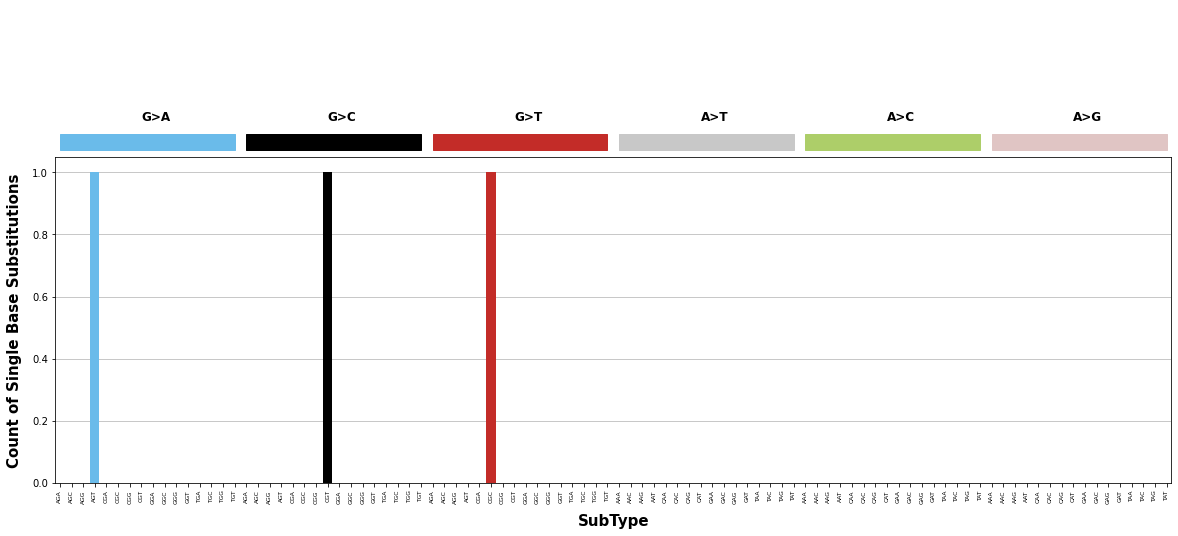

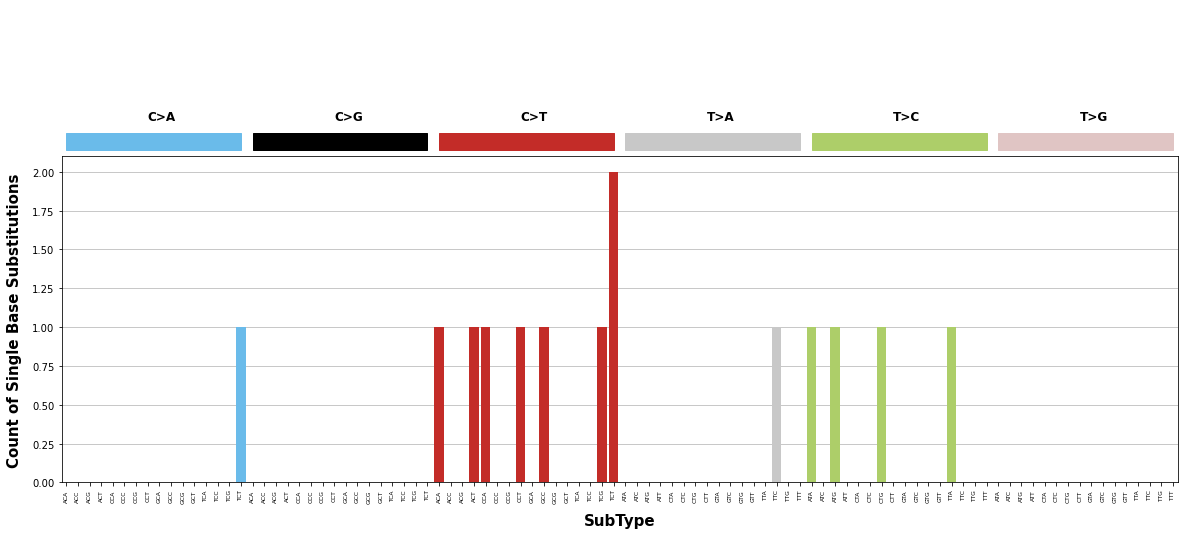

In [99]:
s_purine_02_2020 = sig_table(month="02", year="2020", clade= "S", base_type = "purine", aaf_limit=0.05)
sig_plot(s_purine_02_2020, base_type = "purine")
s_pyrimidine_02_2020 = sig_table(month="02", year="2020", clade= "S", base_type = "pyrimidine", aaf_limit=0.05)
sig_plot(s_pyrimidine_02_2020, base_type = "pyrimidine")

In [122]:
df_S_02_2020 = read_vcf("S_02_2020_snps.vcf")
df_S_02_2020

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NC_045512.2,...,hCoV-19/Beijing/IVDC-BJ-005/2020|EPI_ISL_408485|2020-01-18,hCoV-19/Taiwan/NTU01/2020|EPI_ISL_408489|2020-01-31,hCoV-19/Belgium/GHB-03021/2020|EPI_ISL_407976|2020-02-03,hCoV-19/Australia/QLD03/2020|EPI_ISL_410717|2020-02-05,hCoV-19/Australia/QLD04/2020|EPI_ISL_410718|2020-02-05,hCoV-19/pangolin/Guangdong/1/2019|EPI_ISL_410721|2019,hCoV-19/England/01/2020|EPI_ISL_407071|2020-01-29,hCoV-19/England/02/2020|EPI_ISL_407073|2020-01-29,hCoV-19/USA/WA1-A12/2020|EPI_ISL_407214|2020-01-25,hCoV-19/USA/WA1-F6/2020|EPI_ISL_407215|2020-01-25
0,1,230,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,1,0,0,0,0
1,1,232,.,T,C,.,.,.,GT,0,...,0,0,0,0,0,1,0,0,0,0
2,1,378,.,T,C,.,.,.,GT,0,...,0,0,0,0,0,1,0,0,0,0
3,1,379,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,1,0,0,0,0
4,1,380,.,T,A,.,.,.,GT,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2863,1,29465,.,T,A,.,.,.,GT,0,...,0,0,0,0,0,1,0,0,0,0
2864,1,29537,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,1,0,0,0,0
2865,1,29549,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,1,0,0,0,0
2866,1,29615,.,A,G,.,.,.,GT,0,...,0,0,0,0,0,0,0,1,0,0


In [126]:
filter_vcf(month="02", year="2020", clade="S", aaf_limit=0.05)

,position,reference,alternate
0,2662,C,[T]
1,3177,C,[T]
2,8791,C,[T]
3,13081,C,[T]
4,18069,C,"[T, A]"
5,18497,T,[C]
6,18612,T,[C]
7,18984,T,[A]
8,24053,C,[T]
9,26748,T,[C]


# Clade S: March 2020

1 alternate SNPs included out of a total of 333 SNPs
0 identified SNPs do not match reference base!
1 total SNPs sorted into SBS-192 classification scheme
1 alternate SNPs included out of a total of 333 SNPs
0 identified SNPs do not match reference base!
0 total SNPs sorted into SBS-192 classification scheme


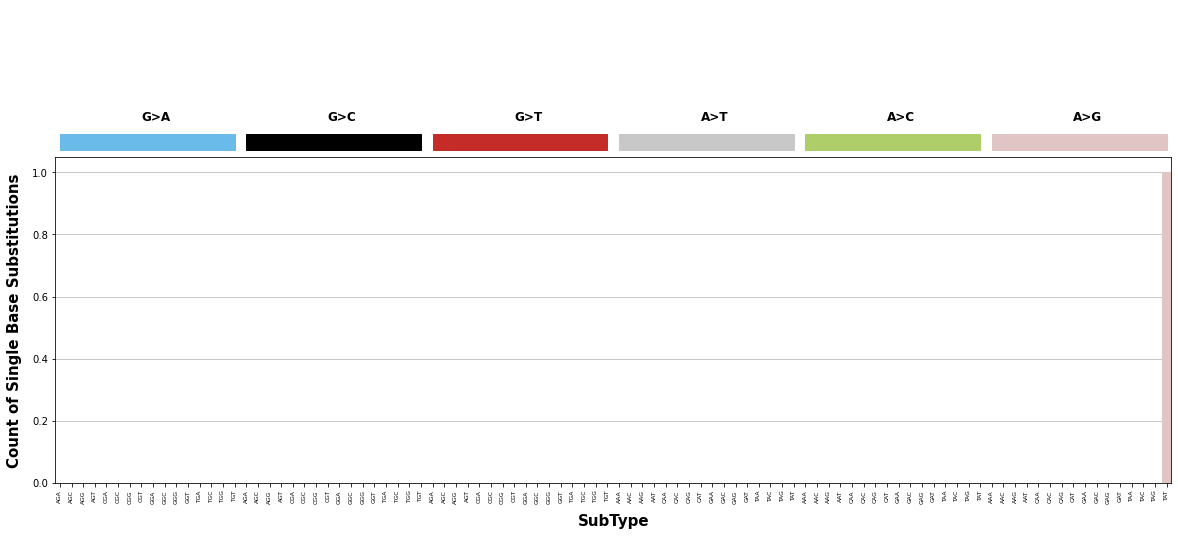

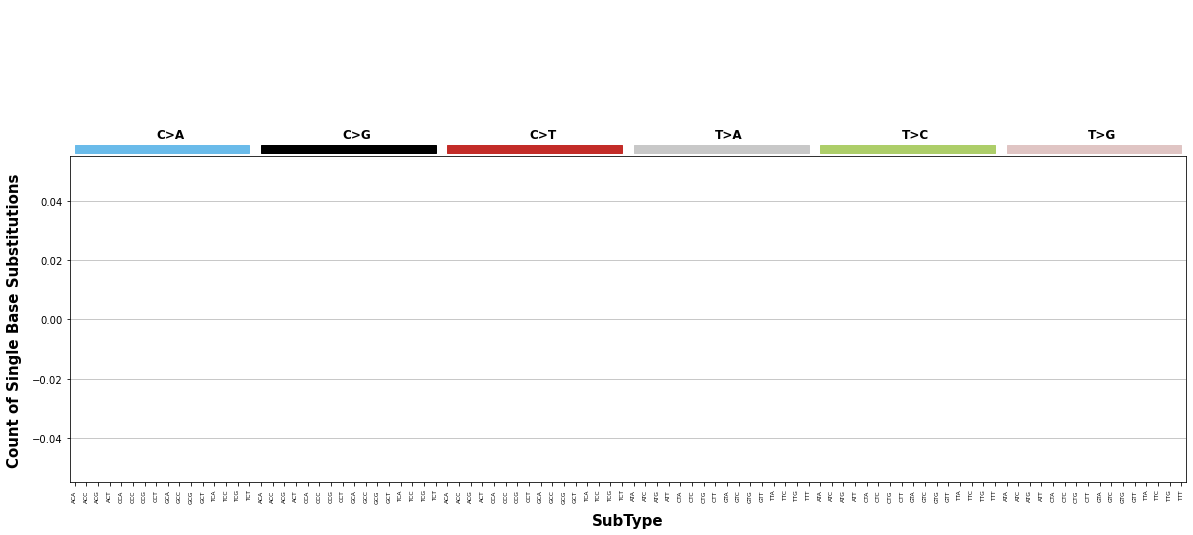

In [128]:
s_purine_03_2020 = sig_table(month="03", year="2020", clade= "S", base_type = "purine", aaf_limit=0.05)
sig_plot(s_purine_03_2020, base_type = "purine")
s_pyrimidine_03_2020 = sig_table(month="03", year="2020", clade= "S", base_type = "pyrimidine", aaf_limit=0.05)
sig_plot(s_pyrimidine_03_2020, base_type = "pyrimidine")

In [114]:
df_S_03_2020 = read_vcf("S_03_2020_snps.vcf")
df_S_03_2020

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NC_045512.2,...,hCoV-19/USA/WA-UW49/2020|EPI_ISL_415614|2020-03-09,hCoV-19/USA/WA-UW50/2020|EPI_ISL_415615|2020-03-08,hCoV-19/USA/WA-UW51/2020|EPI_ISL_415616|2020-03-08,hCoV-19/USA/WA-UW52/2020|EPI_ISL_415617|2020-03-09,hCoV-19/USA/WA-UW54/2020|EPI_ISL_415619|2020-03-09,hCoV-19/USA/WA-UW55/2020|EPI_ISL_415620|2020-03-09,hCoV-19/USA/WA-UW56/2020|EPI_ISL_415621|2020-03-09,hCoV-19/USA/WA-UW57/2020|EPI_ISL_415622|2020-03-09,hCoV-19/USA/WA-UW59/2020|EPI_ISL_415624|2020-03-09,hCoV-19/Chile/Santiago_op2d1/2020|EPI_ISL_415658|2020-03-06
0,1,538,.,A,G,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
1,1,634,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
2,1,910,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
3,1,943,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1024,.,T,C,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,1,29683,.,G,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
329,1,29731,.,A,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
330,1,29793,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
331,1,29844,.,A,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
filter_vcf(month="03", year="2020", clade="S", aaf_limit=0.05)

,position,reference,alternate
0,18401,A,[G]


# Clade S: April 2020

8 alternate SNPs included out of a total of 486 SNPs
0 identified SNPs do not match reference base!
1 total SNPs sorted into SBS-192 classification scheme
8 alternate SNPs included out of a total of 486 SNPs
0 identified SNPs do not match reference base!
7 total SNPs sorted into SBS-192 classification scheme


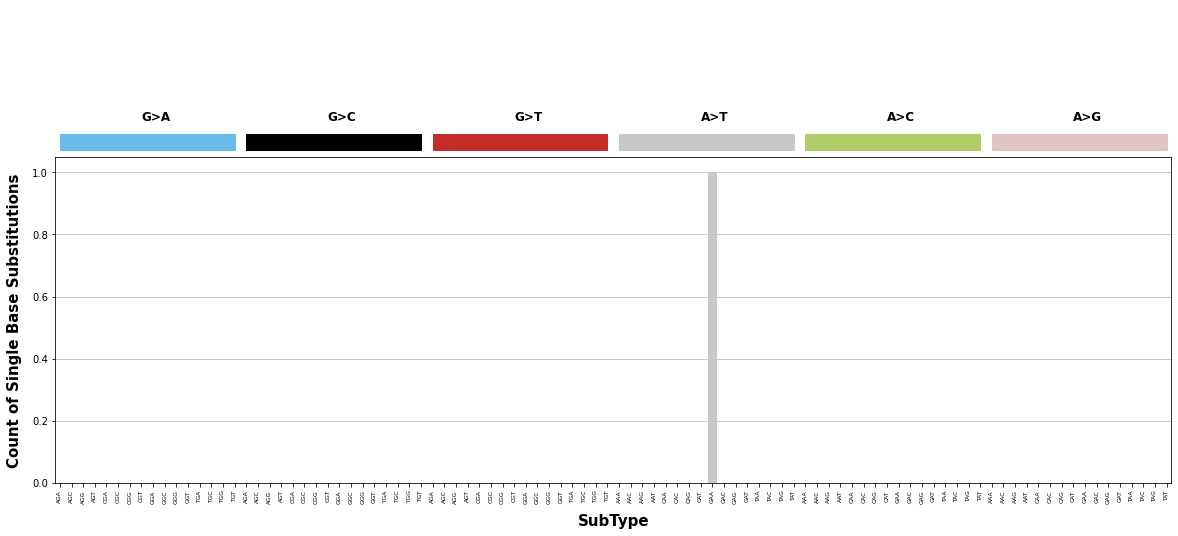

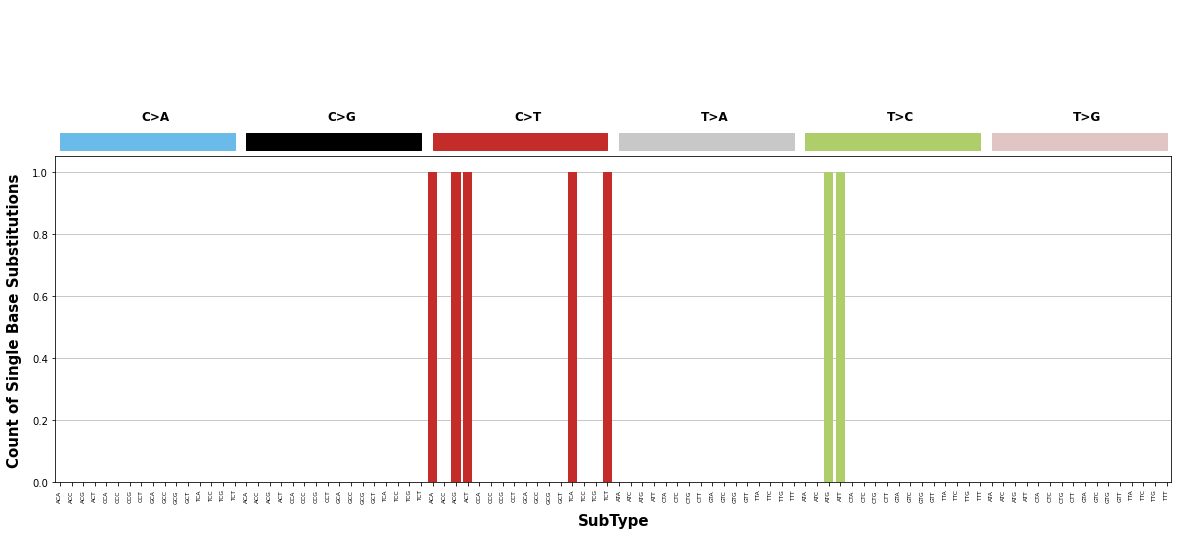

In [129]:
s_purine_04_2020 = sig_table(month="04", year="2020", clade= "S", base_type = "purine", aaf_limit=0.05)
sig_plot(s_purine_04_2020, base_type = "purine")
s_pyrimidine_04_2020 = sig_table(month="04", year="2020", clade= "S", base_type = "pyrimidine", aaf_limit=0.05)
sig_plot(s_pyrimidine_04_2020, base_type = "pyrimidine")

In [130]:
df_S_04_2020 = read_vcf("S_04_2020_snps.vcf")
df_S_04_2020

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NC_045512.2,...,hCoV-19/Mexico/CMX-INCMNSZ-01/2020|EPI_ISL_426361|2020-03-12,hCoV-19/Mexico/CMX-INCMNSZ-02/2020|EPI_ISL_426362|2020-03-10,hCoV-19/Mexico/CMX-INCMNSZ-03/2020|EPI_ISL_426363|2020-03-12,hCoV-19/Mexico/CMX-INCMNSZ-04/2020|EPI_ISL_426364|2020-03-12,hCoV-19/Scotland/CVR1261/2020|EPI_ISL_433525|2020-03-31,hCoV-19/Scotland/CVR1325/2020|EPI_ISL_433541|2020-03-31,hCoV-19/Portugal/PT0064/2020|EPI_ISL_421467|2020-03-20,hCoV-19/USA/CA-CZB0133/2020|EPI_ISL_428995|2020-04-08,hCoV-19/USA/CA-CZB015b/2020|EPI_ISL_428997|2020-03-25,hCoV-19/Scotland/EDB1459/2020|EPI_ISL_433456|2020-04-11
0,1,525,.,G,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
1,1,548,.,C,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
2,1,549,.,T,C,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
3,1,551,.,T,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
4,1,640,.,G,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,1,29935,.,G,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
482,1,29959,.,A,C,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
483,1,29985,.,G,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
484,1,30008,.,G,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
filter_vcf(month="04", year="2020", clade="S", aaf_limit=0.05)

,position,reference,alternate
0,11557,T,[C]
1,15042,C,[T]
2,18297,C,[T]
3,18973,T,[C]
4,24271,C,[T]
5,24931,A,[T]
6,29049,C,[T]
7,29255,C,[T]


# Clade S: May 2020

18 alternate SNPs included out of a total of 587 SNPs
0 identified SNPs do not match reference base!
5 total SNPs sorted into SBS-192 classification scheme
18 alternate SNPs included out of a total of 587 SNPs
0 identified SNPs do not match reference base!
13 total SNPs sorted into SBS-192 classification scheme


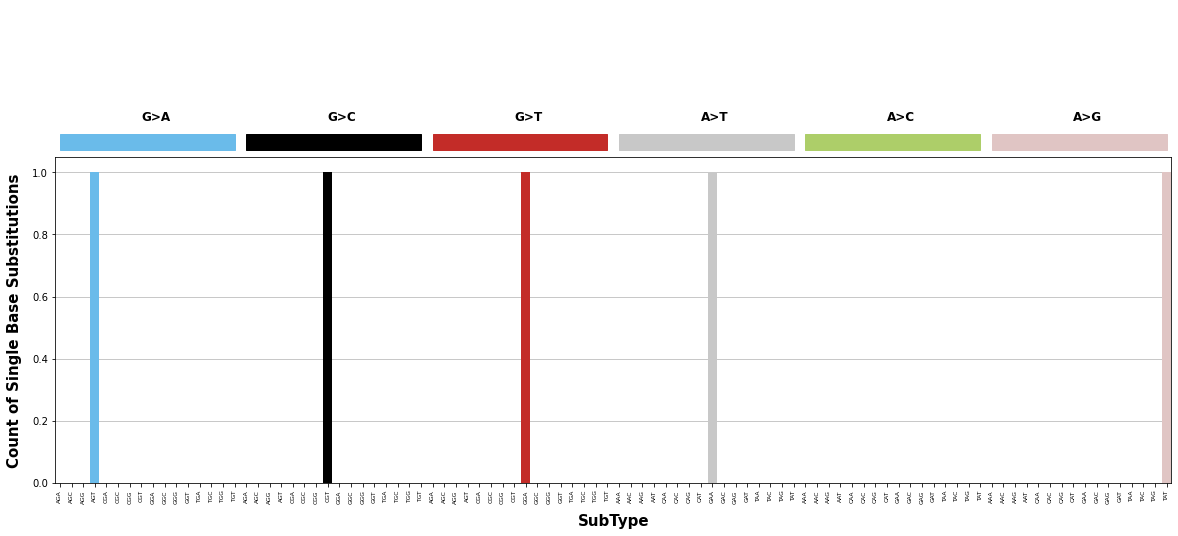

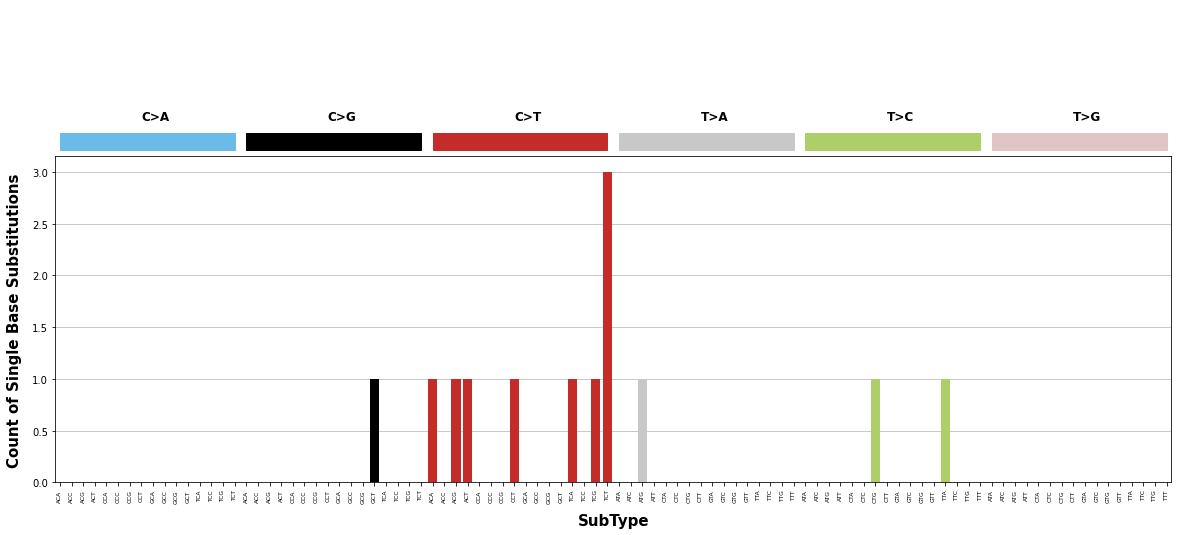

In [141]:
s_purine_05_2020 = sig_table(month="05", year="2020", clade= "S", base_type = "purine", aaf_limit=0.05)
sig_plot(s_purine_05_2020, base_type = "purine")
s_pyrimidine_05_2020 = sig_table(month="05", year="2020", clade= "S", base_type = "pyrimidine", aaf_limit=0.05)
sig_plot(s_pyrimidine_05_2020, base_type = "pyrimidine")

In [112]:
df_S_05_2020 = read_vcf("S_05_2020_snps.vcf")
df_S_05_2020

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NC_045512.2,...,hCoV-19/USA/WA-UW49/2020|EPI_ISL_415614|2020-03-09,hCoV-19/USA/WA-UW50/2020|EPI_ISL_415615|2020-03-08,hCoV-19/USA/WA-UW51/2020|EPI_ISL_415616|2020-03-08,hCoV-19/USA/WA-UW52/2020|EPI_ISL_415617|2020-03-09,hCoV-19/USA/WA-UW54/2020|EPI_ISL_415619|2020-03-09,hCoV-19/USA/WA-UW55/2020|EPI_ISL_415620|2020-03-09,hCoV-19/USA/WA-UW56/2020|EPI_ISL_415621|2020-03-09,hCoV-19/USA/WA-UW57/2020|EPI_ISL_415622|2020-03-09,hCoV-19/USA/WA-UW59/2020|EPI_ISL_415624|2020-03-09,hCoV-19/Chile/Santiago_op2d1/2020|EPI_ISL_415658|2020-03-06
0,1,538,.,A,G,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
1,1,634,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
2,1,910,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
3,1,943,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1024,.,T,C,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,1,29683,.,G,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
329,1,29731,.,A,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
330,1,29793,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
331,1,29844,.,A,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
filter_vcf(month="05", year="2020", clade="S", aaf_limit=0.05)

,position,reference,alternate
0,582,T,[A]
1,3269,C,[T]
2,6132,C,[T]
3,9042,C,[T]
4,14897,C,[T]
5,17950,A,[G]
6,18152,C,[T]
7,24126,C,[T]
8,24786,A,[T]
9,26071,G,[T]


# Clade S: June 2020

11 alternate SNPs included out of a total of 542 SNPs
0 identified SNPs do not match reference base!
3 total SNPs sorted into SBS-192 classification scheme
11 alternate SNPs included out of a total of 542 SNPs
0 identified SNPs do not match reference base!
8 total SNPs sorted into SBS-192 classification scheme


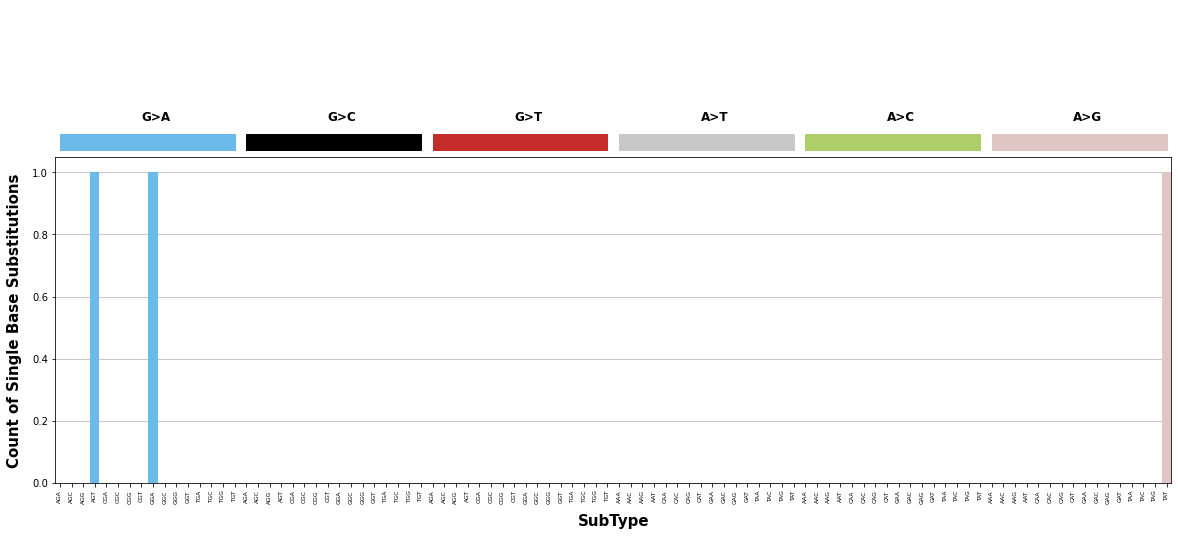

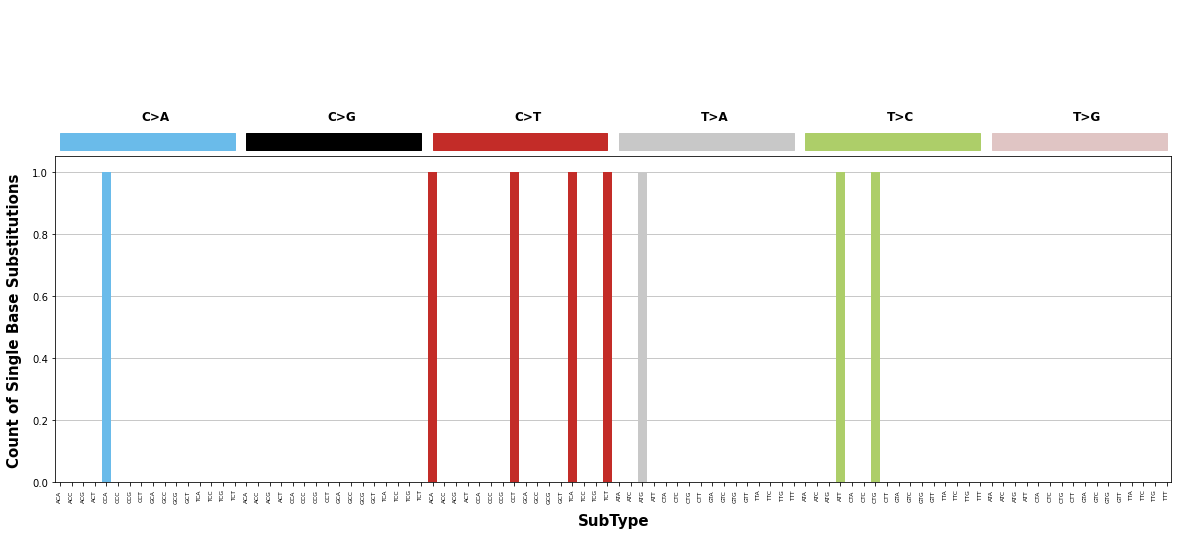

In [140]:
s_purine_06_2020 = sig_table(month="06", year="2020", clade= "S", base_type = "purine", aaf_limit=0.05)
sig_plot(s_purine_06_2020, base_type = "purine")
s_pyrimidine_06_2020 = sig_table(month="06", year="2020", clade= "S", base_type = "pyrimidine", aaf_limit=0.05)
sig_plot(s_pyrimidine_06_2020, base_type = "pyrimidine")

In [111]:
df_S_06_2020 = read_vcf("S_06_2020_snps.vcf")
df_S_06_2020

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NC_045512.2,...,hCoV-19/Canada/BC_16505592/2020|EPI_ISL_477085|2020-03,hCoV-19/Canada/BC_16510082/2020|EPI_ISL_477086|2020-03,hCoV-19/Canada/BC_02038211/2020|EPI_ISL_477088|2020-03,hCoV-19/Canada/BC_07905258/2020|EPI_ISL_477093|2020-04,hCoV-19/Canada/BC_07905790/2020|EPI_ISL_477094|2020-04,hCoV-19/Canada/BC_07911261/2020|EPI_ISL_477095|2020-04,hCoV-19/Canada/BC_07912118/2020|EPI_ISL_477096|2020-04,hCoV-19/Canada/BC_07916655/2020|EPI_ISL_477098|2020-04,hCoV-19/Canada/BC_07917243/2020|EPI_ISL_477099|2020-04,hCoV-19/Scotland/CVR2356/2020|EPI_ISL_477915|2020-04-14
0,1,443,.,G,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
1,1,490,.,T,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
2,1,506,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
3,1,527,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
4,1,625,.,G,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,1,29131,.,A,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
538,1,29143,.,G,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
539,1,29158,.,G,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
540,1,29187,.,T,C,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
filter_vcf(month="06", year="2020", clade="S", aaf_limit=0.05)

,position,reference,alternate
0,490,T,[A]
1,1401,G,[A]
2,3177,C,[T]
3,17861,A,[G]
4,18739,T,[C]
5,24037,C,[T]
6,26187,C,[A]
7,26246,C,[T]
8,26887,T,[C]
9,29021,C,[T]


# Clade S: July 2020

17 alternate SNPs included out of a total of 536 SNPs
0 identified SNPs do not match reference base!
6 total SNPs sorted into SBS-192 classification scheme
17 alternate SNPs included out of a total of 536 SNPs
0 identified SNPs do not match reference base!
11 total SNPs sorted into SBS-192 classification scheme


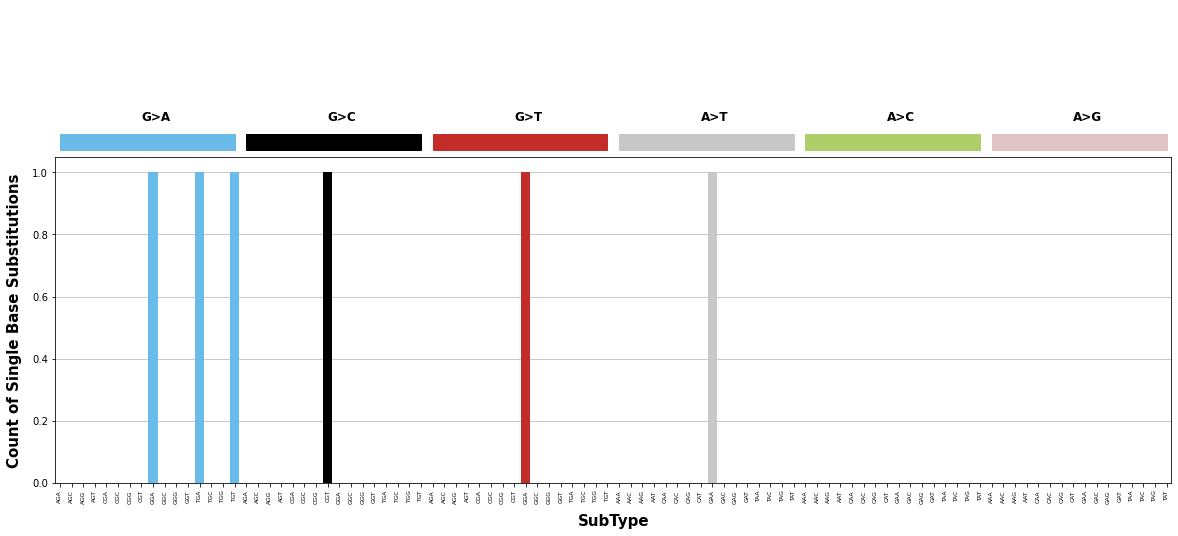

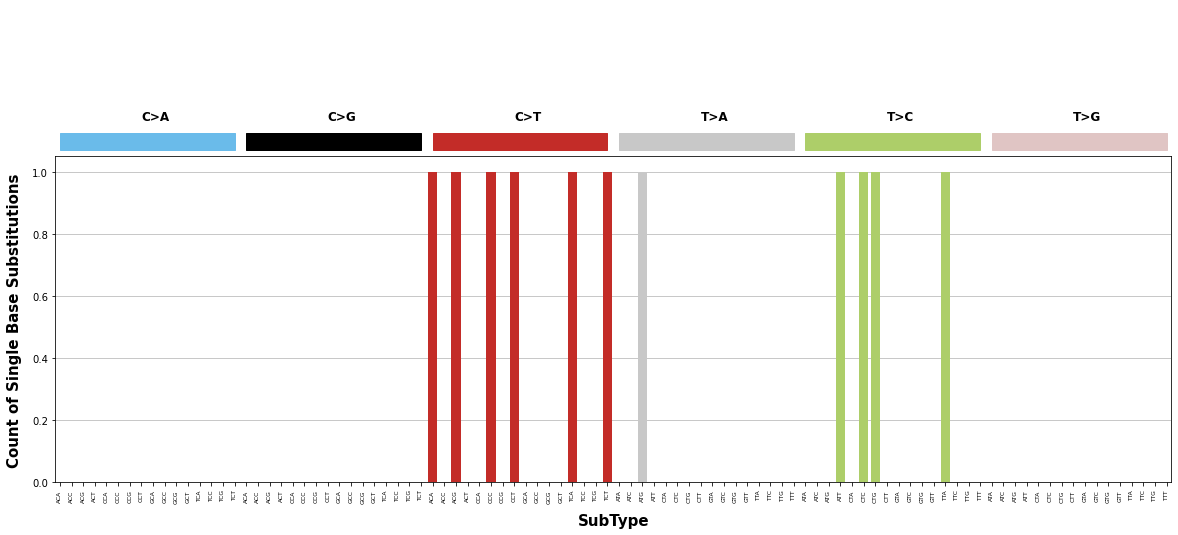

In [139]:
s_purine_07_2020 = sig_table(month="07", year="2020", clade= "S", base_type = "purine", aaf_limit=0.05)
sig_plot(s_purine_07_2020, base_type = "purine")
s_pyrimidine_07_2020 = sig_table(month="07", year="2020", clade= "S", base_type = "pyrimidine", aaf_limit=0.05)
sig_plot(s_pyrimidine_07_2020, base_type = "pyrimidine")

In [110]:
df_S_07_2020 = read_vcf("S_07_2020_snps.vcf")
df_S_07_2020

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NC_045512.2,...,hCoV-19/USA/WA-S1291/2020|EPI_ISL_495741|2020-05-14,hCoV-19/USA/WA-S1298/2020|EPI_ISL_495748|2020-05-15,hCoV-19/USA/WA-S1306/2020|EPI_ISL_495756|2020-05-12,hCoV-19/USA/WA-S1322/2020|EPI_ISL_495772|2020-05-15,hCoV-19/USA/WA-S2073/2020|EPI_ISL_497501|2020-06-05,hCoV-19/USA/WA-S2075/2020|EPI_ISL_497503|2020-06-05,hCoV-19/Australia/NSW2310/2020|EPI_ISL_500705|2020-03-27,hCoV-19/Australia/NSW2314/2020|EPI_ISL_500706|2020-05-24,hCoV-19/USA/WA-UW-9755/2020|EPI_ISL_501162|2020-05-25,hCoV-19/USA/TX-GCID-192000051B/2020|EPI_ISL_501167|2020-03-23
0,1,222,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
1,1,225,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
2,1,483,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
3,1,491,.,T,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,1
4,1,579,.,G,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,1,29657,.,A,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
532,1,29723,.,G,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
533,1,29728,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
534,1,29834,.,A,G,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
filter_vcf(month="07", year="2020", clade="S", aaf_limit=0.05)

,position,reference,alternate
0,491,T,[A]
1,1402,G,[A]
2,3178,C,[T]
3,3180,G,[A]
4,16537,G,[A]
5,18188,T,[C]
6,19047,T,[C]
7,24500,C,[T]
8,25160,A,[T]
9,26448,G,[T]


# Clade S: August 2020

26 alternate SNPs included out of a total of 325 SNPs
0 identified SNPs do not match reference base!
13 total SNPs sorted into SBS-192 classification scheme
26 alternate SNPs included out of a total of 325 SNPs
0 identified SNPs do not match reference base!
13 total SNPs sorted into SBS-192 classification scheme


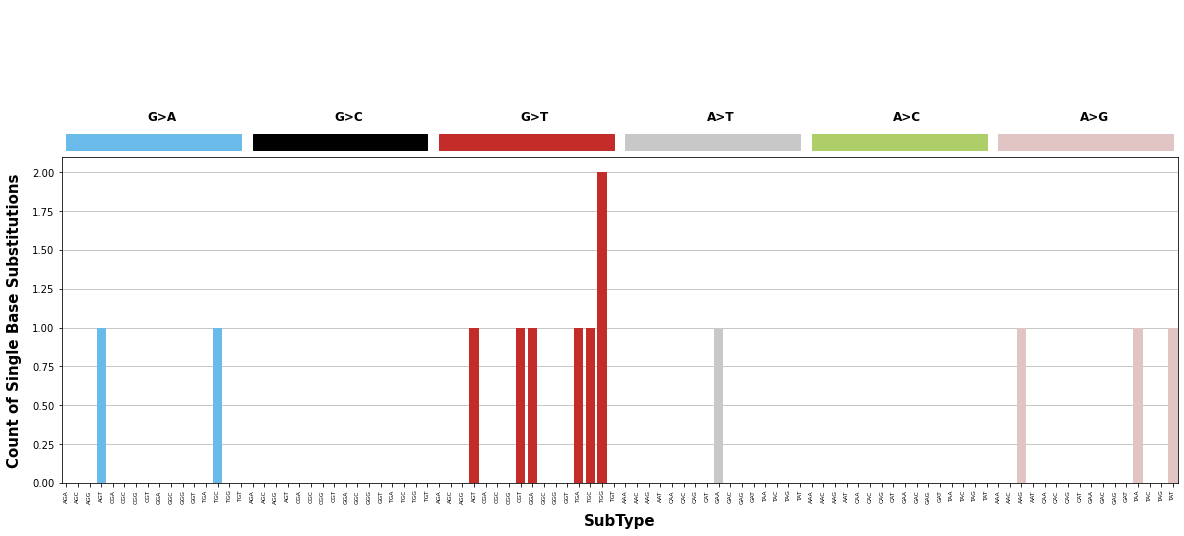

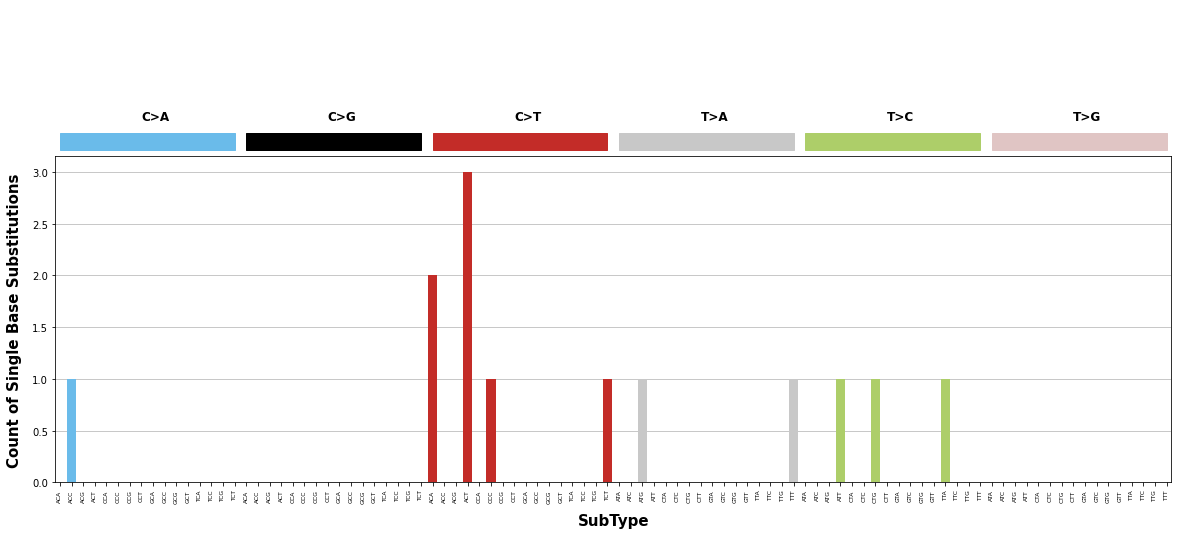

In [138]:
s_purine_08_2020 = sig_table(month="08", year="2020", clade= "S", base_type = "purine", aaf_limit=0.05)
sig_plot(s_purine_08_2020, base_type = "purine")
s_pyrimidine_08_2020 = sig_table(month="08", year="2020", clade= "S", base_type = "pyrimidine", aaf_limit=0.05)
sig_plot(s_pyrimidine_08_2020, base_type = "pyrimidine")

In [109]:
df_S_08_2020 = read_vcf("S_08_2020_snps.vcf")
df_S_08_2020

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NC_045512.2,...,hCoV-19/Netherlands/NB-EMC-198/2020|EPI_ISL_523321|2020,hCoV-19/England/LOND-1260476/2020|EPI_ISL_524665|2020-03-13,hCoV-19/USA/MN-MDH-1461/2020|EPI_ISL_518855|2020-05-06,hCoV-19/USA/MN-MDH-1466/2020|EPI_ISL_518860|2020-03-23,hCoV-19/USA/MN-MDH-1469/2020|EPI_ISL_518863|2020-03-23,hCoV-19/USA/MN-MDH-1472/2020|EPI_ISL_518866|2020-03-27,hCoV-19/USA/MN-MDH-1474/2020|EPI_ISL_518868|2020-03-18,hCoV-19/USA/MN-MDH-1475/2020|EPI_ISL_518869|2020-03-23,hCoV-19/USA/MN-MDH-1501/2020|EPI_ISL_518894|2020-03-19,hCoV-19/Mexico/CMX-INMEGEN-12/2020|EPI_ISL_522942|2020-08-06
0,1,331,.,G,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
1,1,335,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
2,1,344,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
3,1,361,.,A,G,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
4,1,383,.,T,C,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,1,29477,.,G,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
321,1,29549,.,C,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
322,1,29570,.,A,C,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
323,1,29619,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
filter_vcf(month="08", year="2020", clade="S", aaf_limit=0.05)

,position,reference,alternate
0,490,T,[A]
1,895,A,[G]
2,2942,C,[T]
3,4390,G,[T]
4,4540,C,[T]
5,4624,A,[G]
6,5017,G,[T]
7,9477,T,[A]
8,9598,C,[T]
9,14353,G,[T]


# Clade S: September 2020

21 alternate SNPs included out of a total of 302 SNPs
0 identified SNPs do not match reference base!
5 total SNPs sorted into SBS-192 classification scheme
21 alternate SNPs included out of a total of 302 SNPs
0 identified SNPs do not match reference base!
16 total SNPs sorted into SBS-192 classification scheme


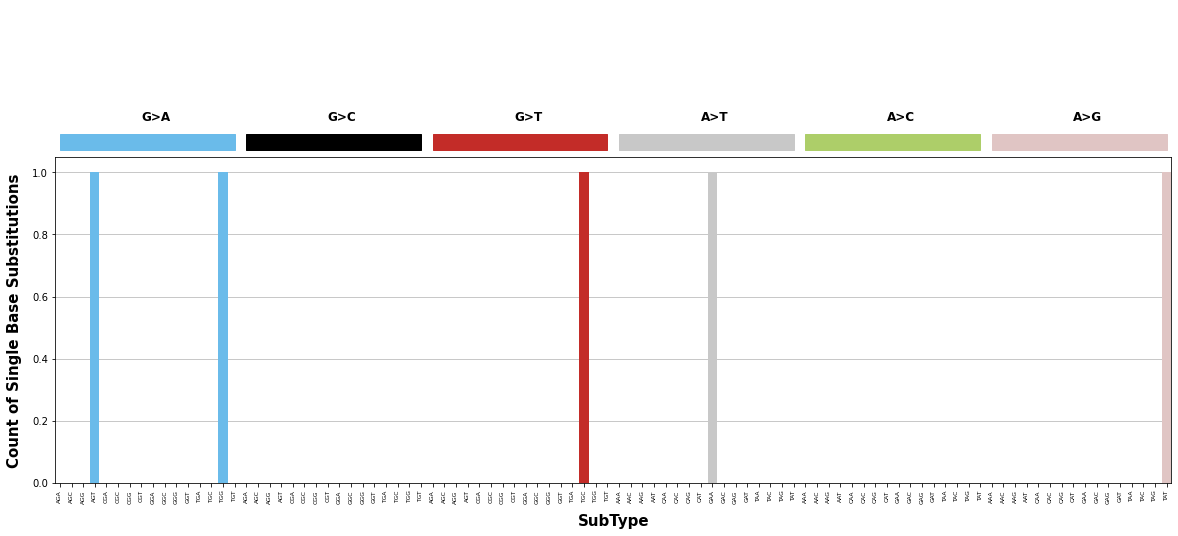

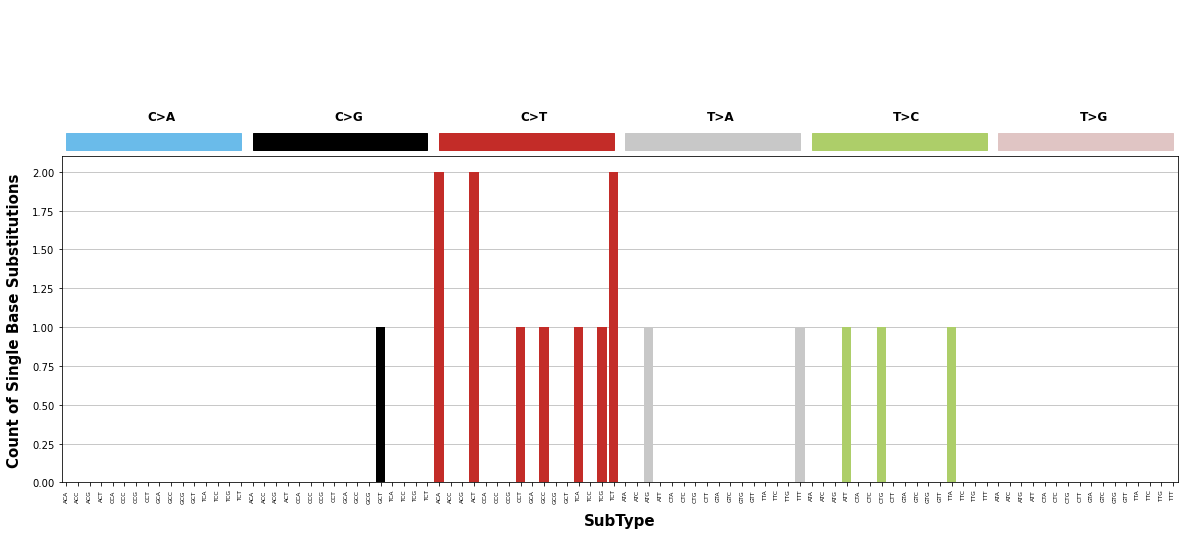

In [137]:
s_purine_09_2020 = sig_table(month="09", year="2020", clade= "S", base_type = "purine", aaf_limit=0.05)
sig_plot(s_purine_09_2020, base_type = "purine")
s_pyrimidine_09_2020 = sig_table(month="09", year="2020", clade= "S", base_type = "pyrimidine", aaf_limit=0.05)
sig_plot(s_pyrimidine_09_2020, base_type = "pyrimidine")

In [108]:
df_S_09_2020 = read_vcf("S_09_2020_snps.vcf")
df_S_09_2020

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NC_045512.2,...,hCoV-19/Singapore/921/2020|EPI_ISL_538452|2020-03-23,hCoV-19/Singapore/925/2020|EPI_ISL_538456|2020-03-25,hCoV-19/Singapore/926/2020|EPI_ISL_538458|2020-03-26,hCoV-19/USA/FL-BPHL-1227/2020|EPI_ISL_541237|2020-03-30,hCoV-19/USA/TX-HMH-1120/2020|EPI_ISL_542542|2020-04-22,hCoV-19/USA/TX-HMH-1164/2020|EPI_ISL_542562|2020-04-26,hCoV-19/USA/TX-HMH-1185/2020|EPI_ISL_542573|2020-04-01,hCoV-19/USA/TX-HMH-1213/2020|EPI_ISL_542587|2020-03-31,hCoV-19/USA/TX-HMH-765/2020|EPI_ISL_546913|2020-04-02,hCoV-19/USA/TX-HMH-568/2020|EPI_ISL_546940|2020-04-09
0,1,241,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
1,1,300,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
2,1,350,.,C,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
3,1,364,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
4,1,374,.,G,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1,29554,.,G,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
298,1,29567,.,A,C,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
299,1,29596,.,A,G,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
300,1,29619,.,T,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
filter_vcf(month="09", year="2020", clade="S", aaf_limit=0.05)

,position,reference,alternate
0,490,T,[A]
1,3177,C,[T]
2,4540,C,[T]
3,6040,C,[T]
4,8782,C,[T]
5,8950,C,[T]
6,9477,T,[A]
7,11230,G,[T]
8,12478,G,[A]
9,14805,C,[T]


# Clade S

1799 alternate SNPs included out of a total of 1799 SNPs
0 identified SNPs do not match reference base!
784 total SNPs sorted into SBS-192 classification scheme
1799 alternate SNPs included out of a total of 1799 SNPs
0 identified SNPs do not match reference base!
1084 total SNPs sorted into SBS-192 classification scheme


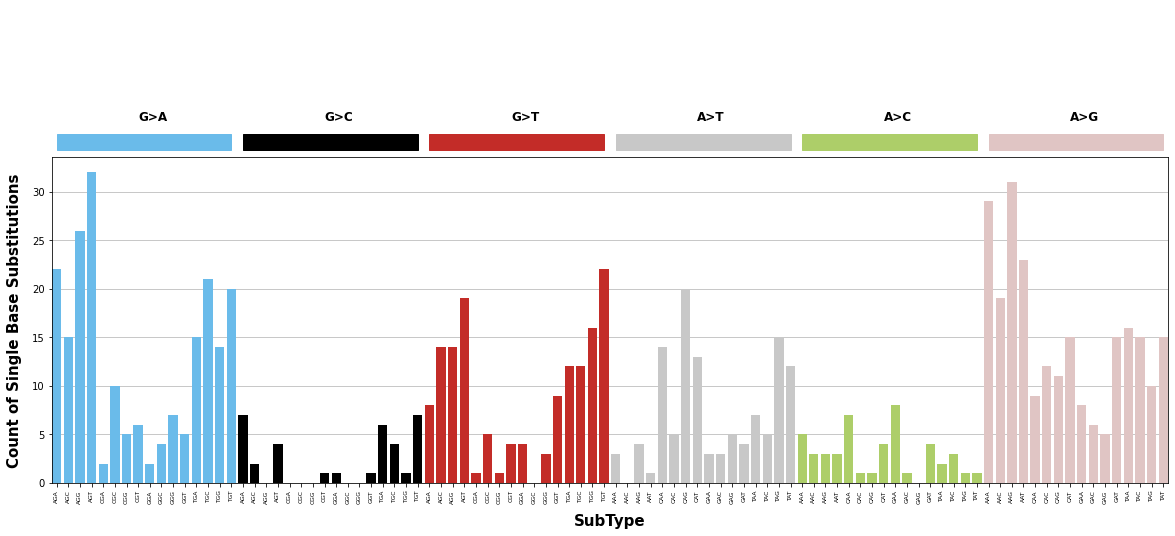

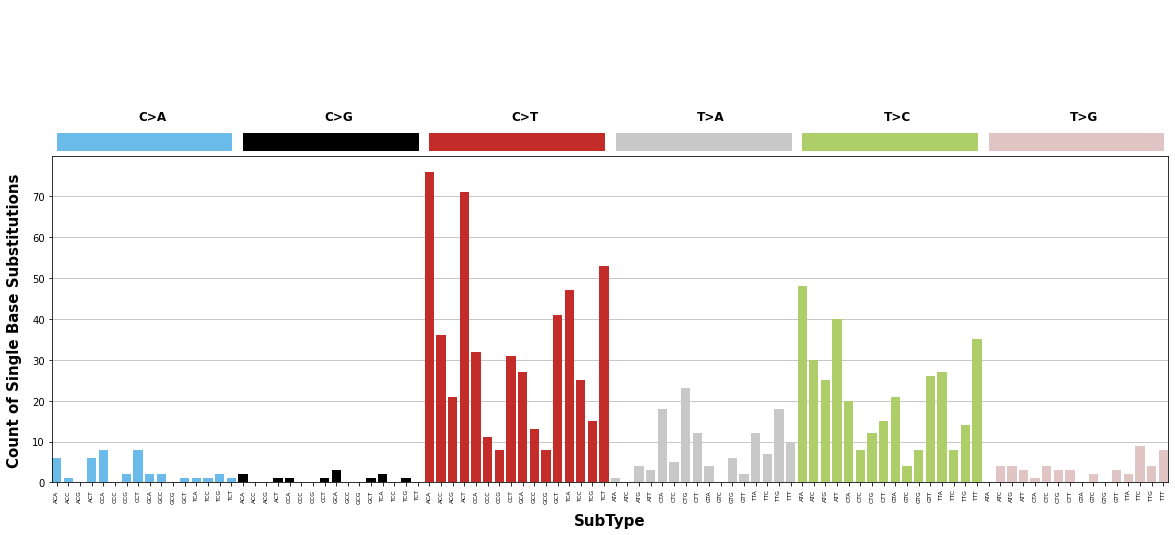

In [405]:
s_purine = sig_table("/Users/davidchen/Desktop/Mutation_signature/S/gisaid_hcov_19_S_snps.vcf", clade= "S", base_type = "purine", aaf_limit=0)
sig_plot(s_purine, base_type = "purine")
s_pyrimidine = sig_table("/Users/davidchen/Desktop/Mutation_signature/S/gisaid_hcov_19_S_snps.vcf", clade= "S", base_type = "pyrimidine", aaf_limit=0)
sig_plot(s_pyrimidine, base_type = "pyrimidine")

# Clade O

817 alternate SNPs included out of a total of 817 SNPs
0 identified SNPs do not match reference base!
378 total SNPs sorted into SBS-192 classification scheme
817 alternate SNPs included out of a total of 817 SNPs
0 identified SNPs do not match reference base!
457 total SNPs sorted into SBS-192 classification scheme


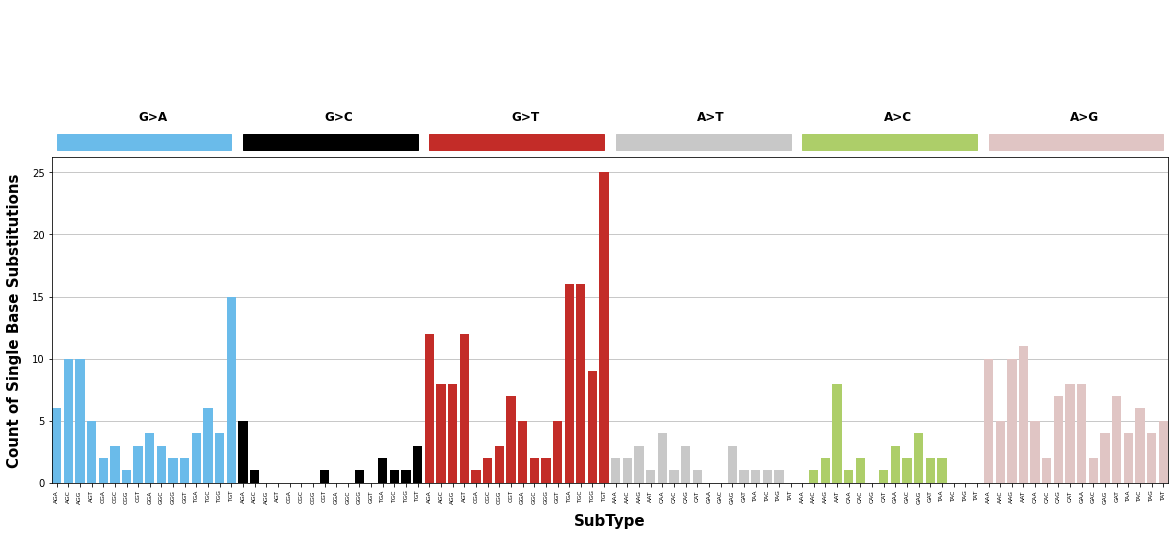

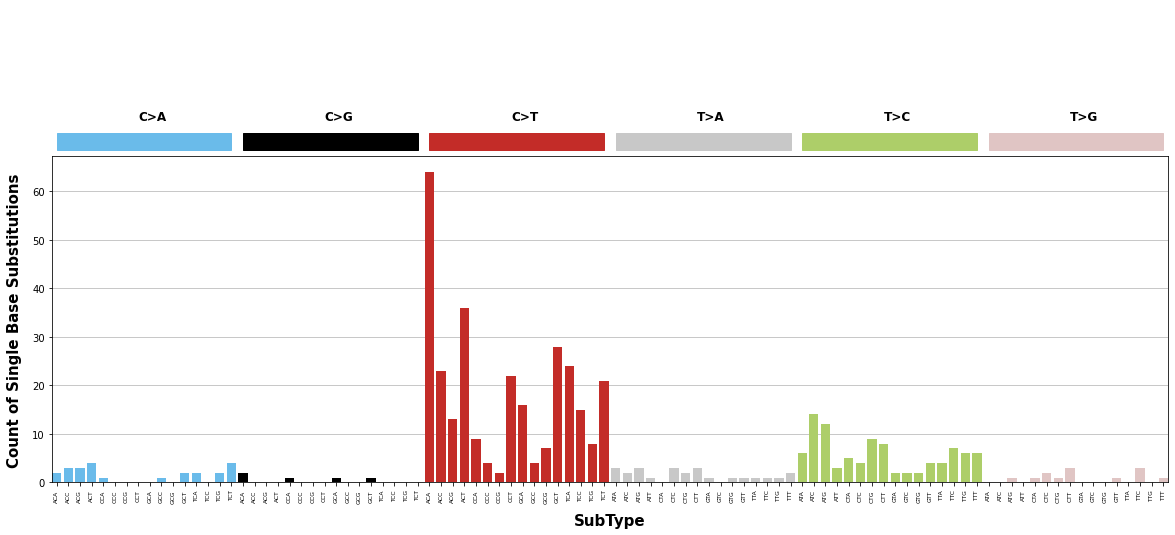

In [406]:
o_purine = sig_table("/Users/davidchen/Desktop/Mutation_signature/O/gisaid_hcov_19_O_snps.vcf", clade= "O", base_type = "purine", aaf_limit=0)
sig_plot(o_purine, base_type = "purine")
o_pyrimidine = sig_table("/Users/davidchen/Desktop/Mutation_signature/O/gisaid_hcov_19_O_snps.vcf", clade= "O", base_type = "pyrimidine", aaf_limit=0)
sig_plot(o_pyrimidine, base_type = "pyrimidine")

# Clade V

1047 alternate SNPs included out of a total of 1047 SNPs
0 identified SNPs do not match reference base!
469 total SNPs sorted into SBS-192 classification scheme
1047 alternate SNPs included out of a total of 1047 SNPs
0 identified SNPs do not match reference base!
595 total SNPs sorted into SBS-192 classification scheme


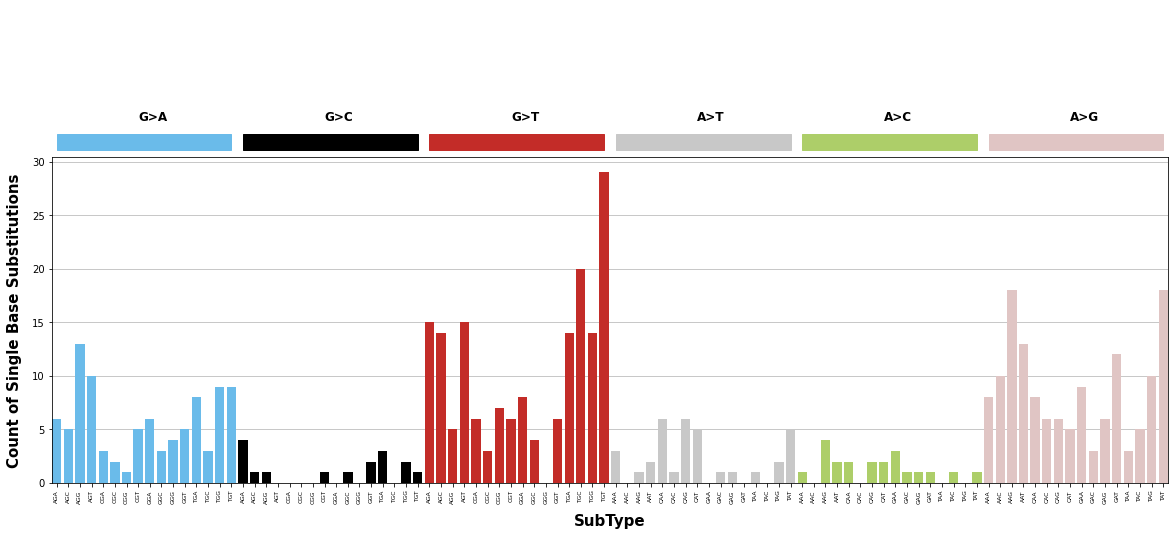

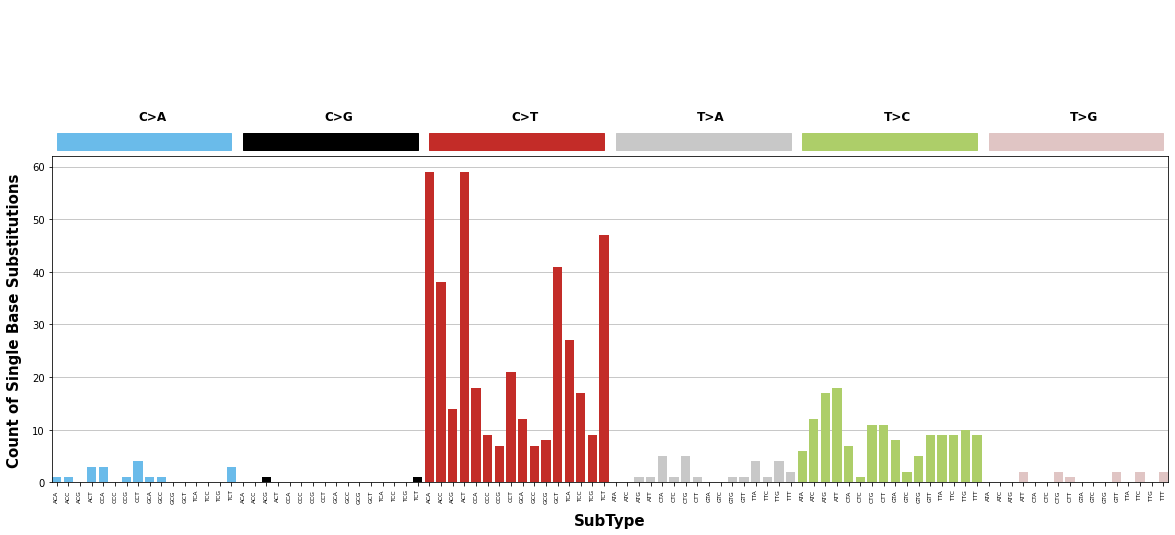

In [409]:
v_purine = sig_table("/Users/davidchen/Desktop/Mutation_signature/V/gisaid_hcov_19_V_snps.vcf", clade= "V", base_type = "purine", aaf_limit=0)
sig_plot(v_purine, base_type = "purine")
v_pyrimidine = sig_table("/Users/davidchen/Desktop/Mutation_signature/V/gisaid_hcov_19_V_snps.vcf", clade= "V", base_type = "pyrimidine", aaf_limit=0)
sig_plot(v_pyrimidine, base_type = "pyrimidine")

# Clade GH

478 alternate SNPs included out of a total of 478 SNPs
0 identified SNPs do not match reference base!
248 total SNPs sorted into SBS-192 classification scheme
478 alternate SNPs included out of a total of 478 SNPs
0 identified SNPs do not match reference base!
284 total SNPs sorted into SBS-192 classification scheme


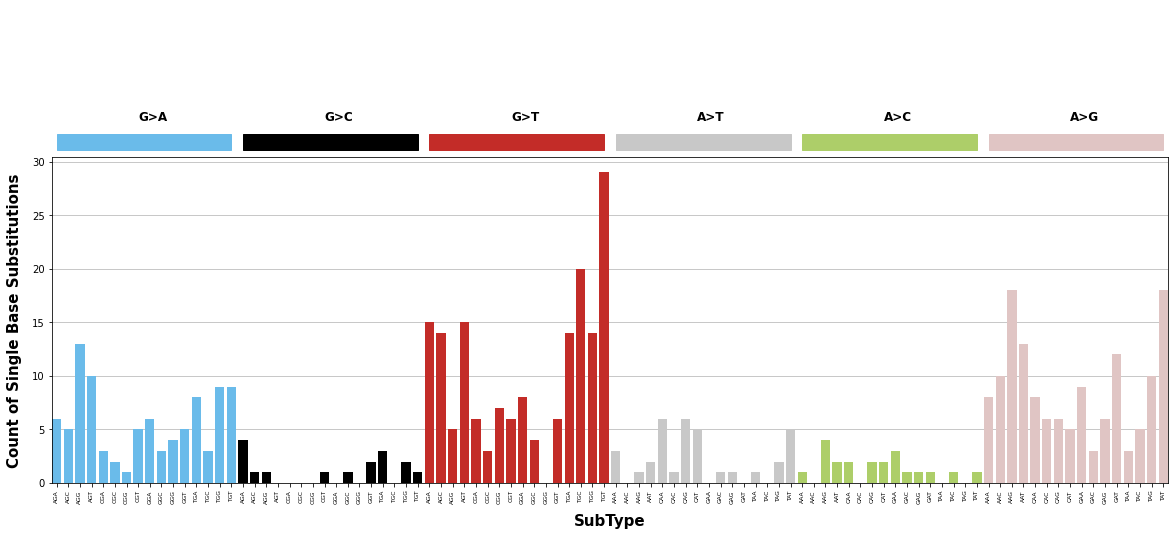

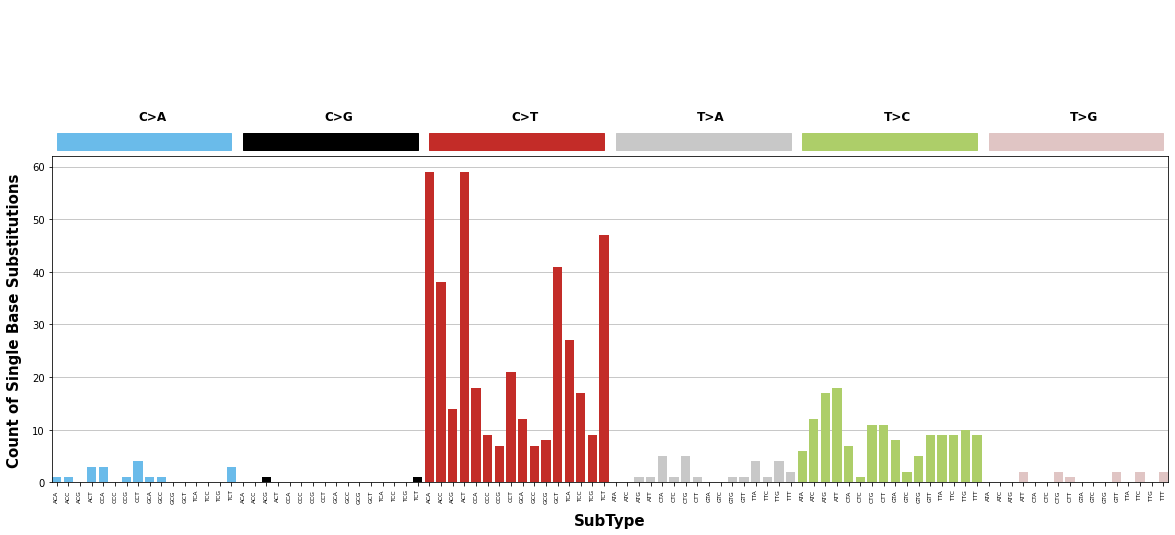

In [411]:
gh_purine = sig_table("/Users/davidchen/Desktop/Mutation_signature/GH/gisaid_hcov_19_GH_snps.vcf", clade= "GH", base_type = "purine", aaf_limit=0)
sig_plot(v_purine, base_type = "purine")
gh_pyrimidine = sig_table("/Users/davidchen/Desktop/Mutation_signature/GH/gisaid_hcov_19_GH_snps.vcf", clade= "GH", base_type = "pyrimidine", aaf_limit=0)
sig_plot(v_pyrimidine, base_type = "pyrimidine")

# Clade G

559 alternate SNPs included out of a total of 559 SNPs
0 identified SNPs do not match reference base!
328 total SNPs sorted into SBS-192 classification scheme
559 alternate SNPs included out of a total of 559 SNPs
0 identified SNPs do not match reference base!
282 total SNPs sorted into SBS-192 classification scheme


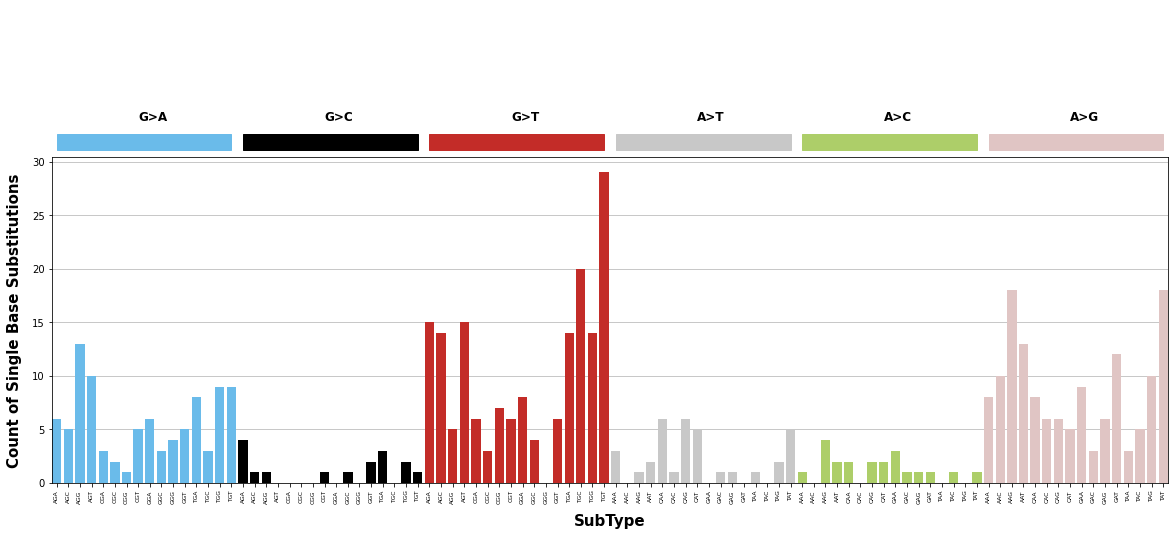

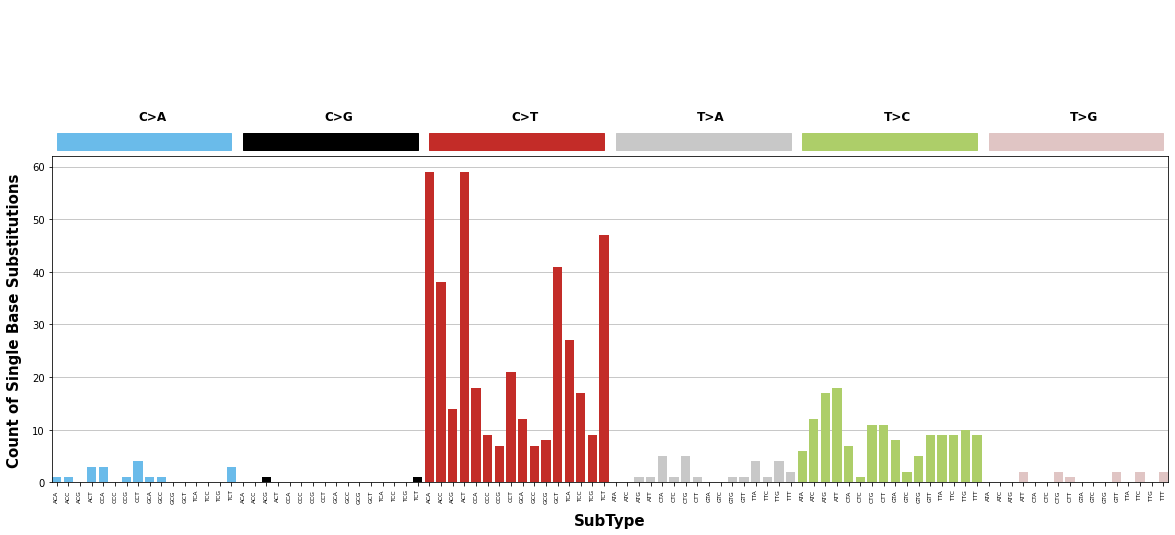

In [412]:
g_purine = sig_table("/Users/davidchen/Desktop/Mutation_signature/G/gisaid_hcov_19_G_snps.vcf", clade= "G", base_type = "purine", aaf_limit=0)
sig_plot(v_purine, base_type = "purine")
g_pyrimidine = sig_table("/Users/davidchen/Desktop/Mutation_signature/G/gisaid_hcov_19_G_snps.vcf", clade= "G", base_type = "pyrimidine", aaf_limit=0)
sig_plot(v_pyrimidine, base_type = "pyrimidine")

# Clade GR

In [ ]:
g_purine = sig_table("/Users/davidchen/Desktop/Mutation_signature/G/gisaid_hcov_19_G_snps.vcf", clade= "G", base_type = "purine", aaf_limit=0)
sig_plot(v_purine, base_type = "purine")
g_pyrimidine = sig_table("/Users/davidchen/Desktop/Mutation_signature/G/gisaid_hcov_19_G_snps.vcf", clade= "G", base_type = "pyrimidine", aaf_limit=0)
sig_plot(v_pyrimidine, base_type = "pyrimidine")

# Alternate Allele Frequency in at least 1% of the population

# Clade L

16 alternate SNPs included out of a total of 1071 SNPs
0 identified SNPs do not match reference base!
6 total SNPs sorted into SBS-192 classification scheme
16 alternate SNPs included out of a total of 1071 SNPs
0 identified SNPs do not match reference base!
10 total SNPs sorted into SBS-192 classification scheme


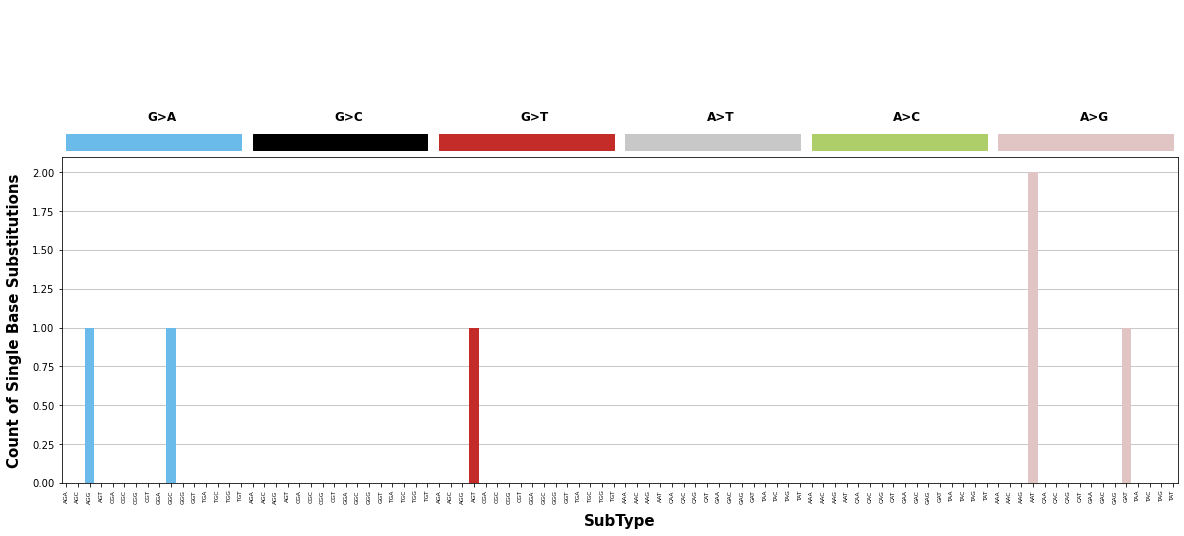

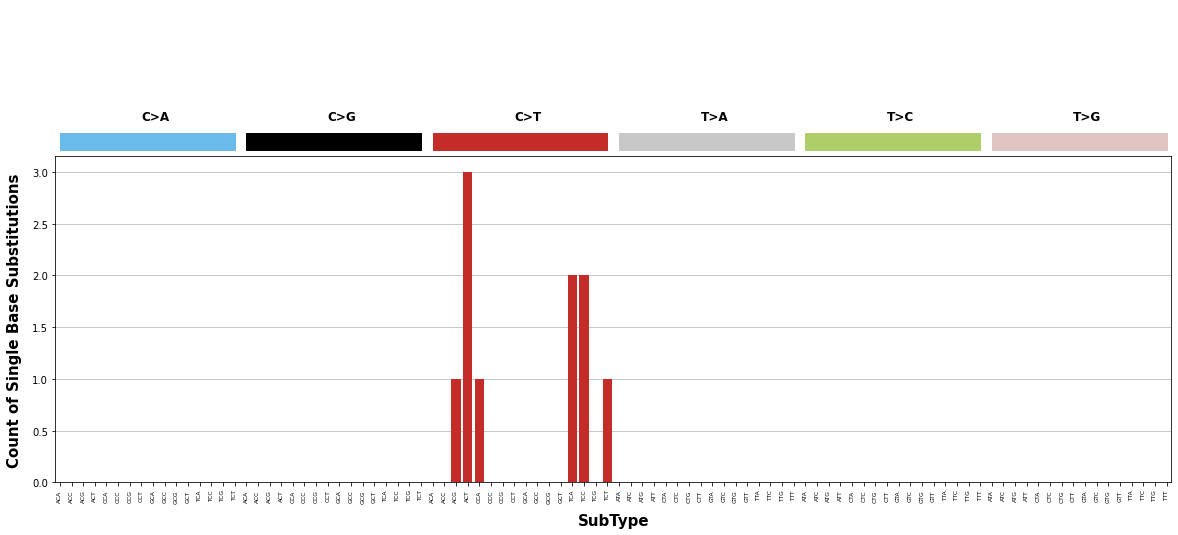

In [414]:
l_purine = sig_table("/Users/davidchen/Desktop/Mutation_signature/L/gisaid_hcov-19_L_snps.vcf", clade= "L", base_type = "purine", aaf_limit=0.01)
sig_plot(l_purine, base_type = "purine")
l_pyrimidine = sig_table("/Users/davidchen/Desktop/Mutation_signature/L/gisaid_hcov-19_L_snps.vcf", clade= "L", base_type = "pyrimidine", aaf_limit=0.01)
sig_plot(l_pyrimidine, base_type = "pyrimidine")

# Clade G

11 alternate SNPs included out of a total of 1799 SNPs
0 identified SNPs do not match reference base!
7 total SNPs sorted into SBS-192 classification scheme
11 alternate SNPs included out of a total of 1799 SNPs
0 identified SNPs do not match reference base!
5 total SNPs sorted into SBS-192 classification scheme


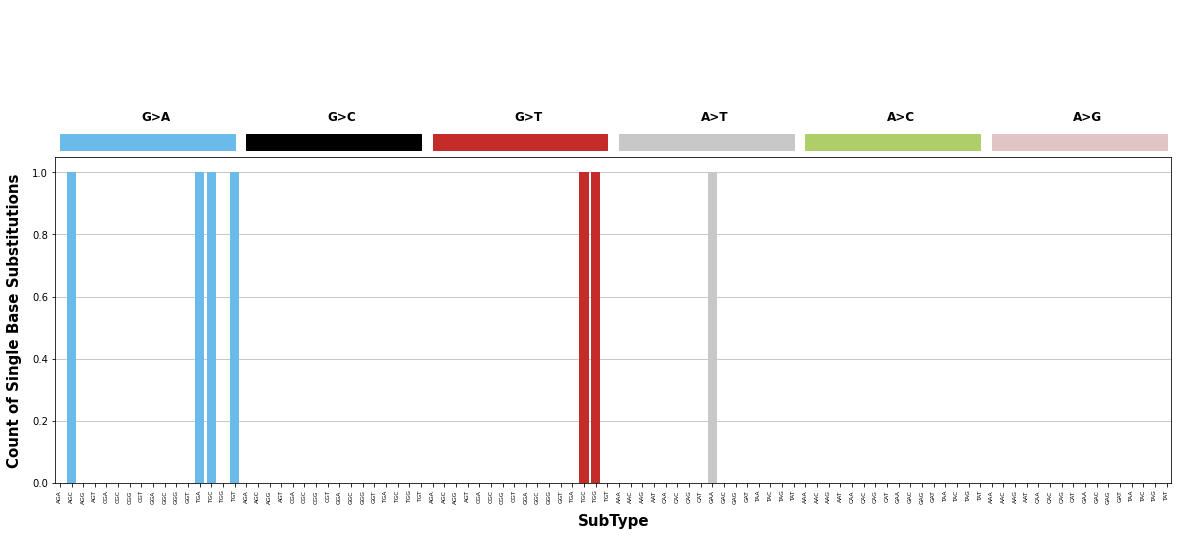

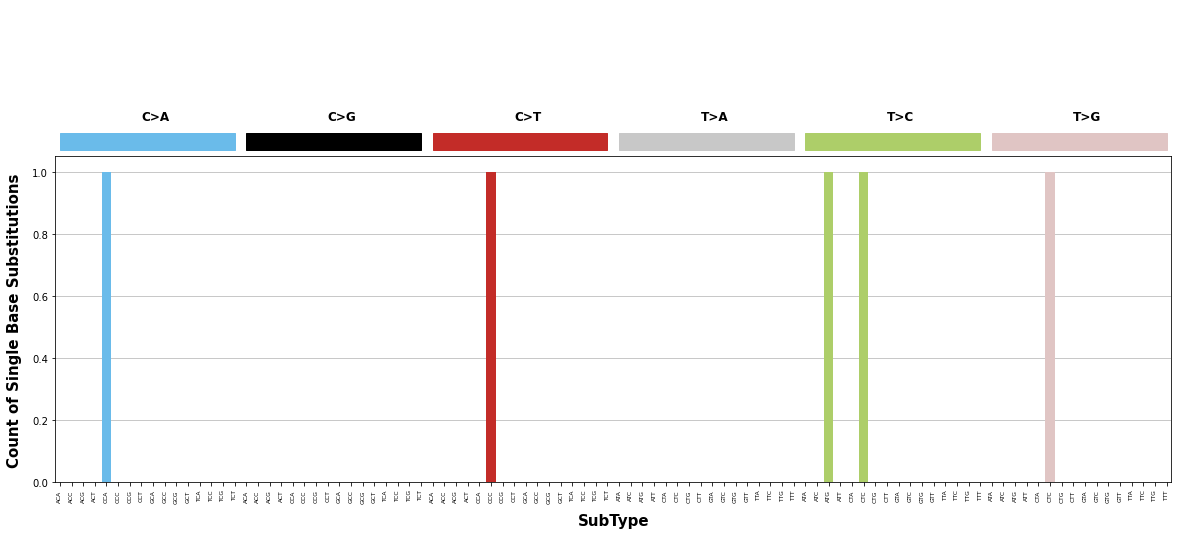

In [415]:
s_purine = sig_table("/Users/davidchen/Desktop/Mutation_signature/S/gisaid_hcov_19_S_snps.vcf", clade= "S", base_type = "purine", aaf_limit=0.01)
sig_plot(s_purine, base_type = "purine")
s_pyrimidine = sig_table("/Users/davidchen/Desktop/Mutation_signature/S/gisaid_hcov_19_S_snps.vcf", clade= "S", base_type = "pyrimidine", aaf_limit=0.01)
sig_plot(s_pyrimidine, base_type = "pyrimidine")

# Clade O

2 alternate SNPs included out of a total of 817 SNPs
0 identified SNPs do not match reference base!
0 total SNPs sorted into SBS-192 classification scheme
2 alternate SNPs included out of a total of 817 SNPs
0 identified SNPs do not match reference base!
2 total SNPs sorted into SBS-192 classification scheme


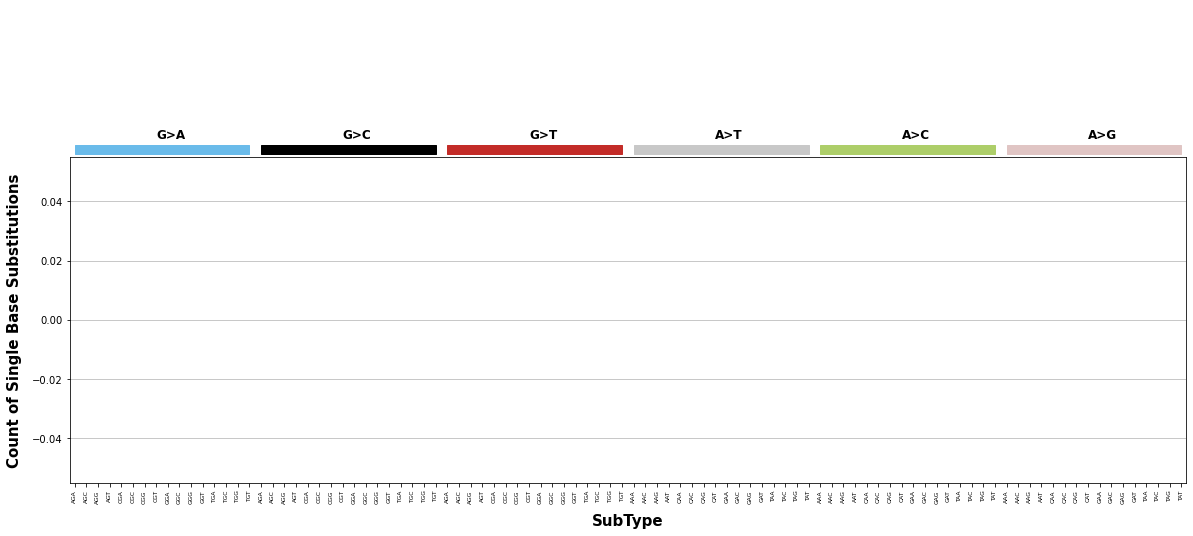

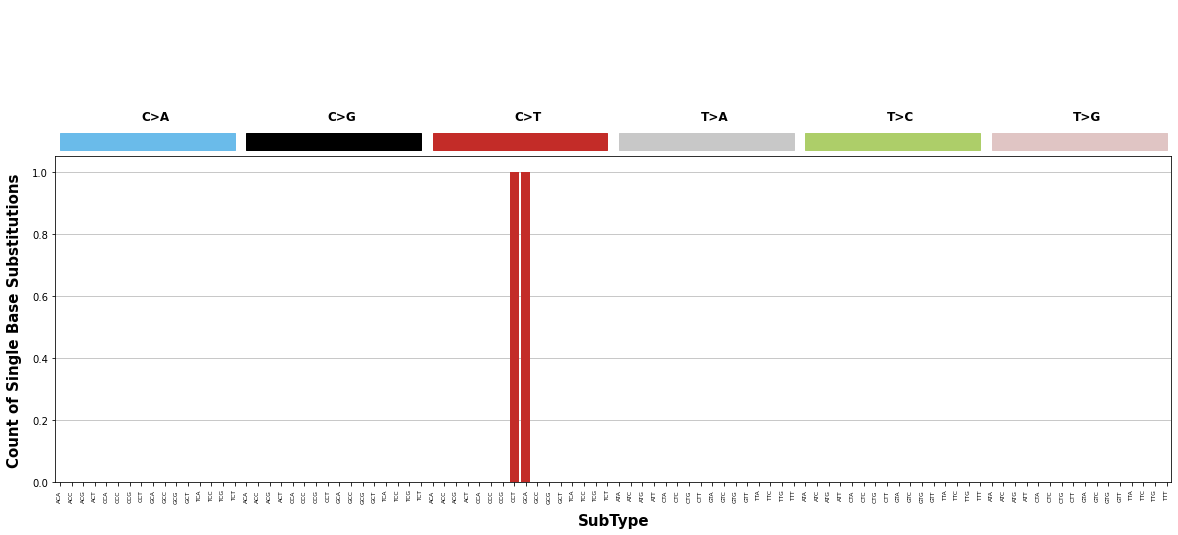

In [416]:
o_purine = sig_table("/Users/davidchen/Desktop/Mutation_signature/O/gisaid_hcov_19_O_snps.vcf", clade= "O", base_type = "purine", aaf_limit=0.01)
sig_plot(o_purine, base_type = "purine")
o_pyrimidine = sig_table("/Users/davidchen/Desktop/Mutation_signature/O/gisaid_hcov_19_O_snps.vcf", clade= "O", base_type = "pyrimidine", aaf_limit=0.01)
sig_plot(o_pyrimidine, base_type = "pyrimidine")

# Clade V

11 alternate SNPs included out of a total of 1047 SNPs
0 identified SNPs do not match reference base!
5 total SNPs sorted into SBS-192 classification scheme
11 alternate SNPs included out of a total of 1047 SNPs
0 identified SNPs do not match reference base!
6 total SNPs sorted into SBS-192 classification scheme


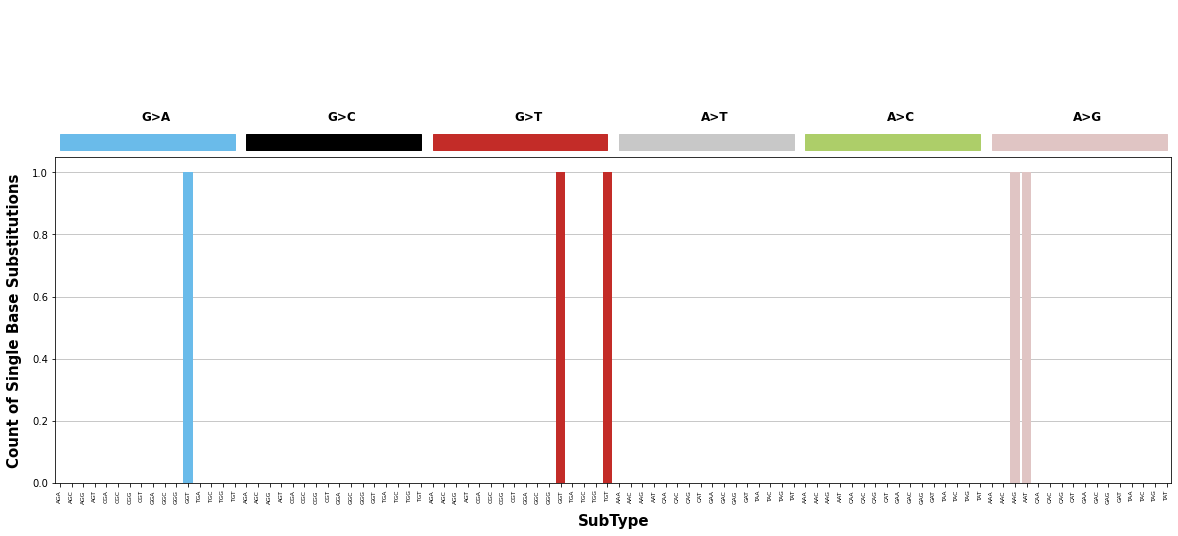

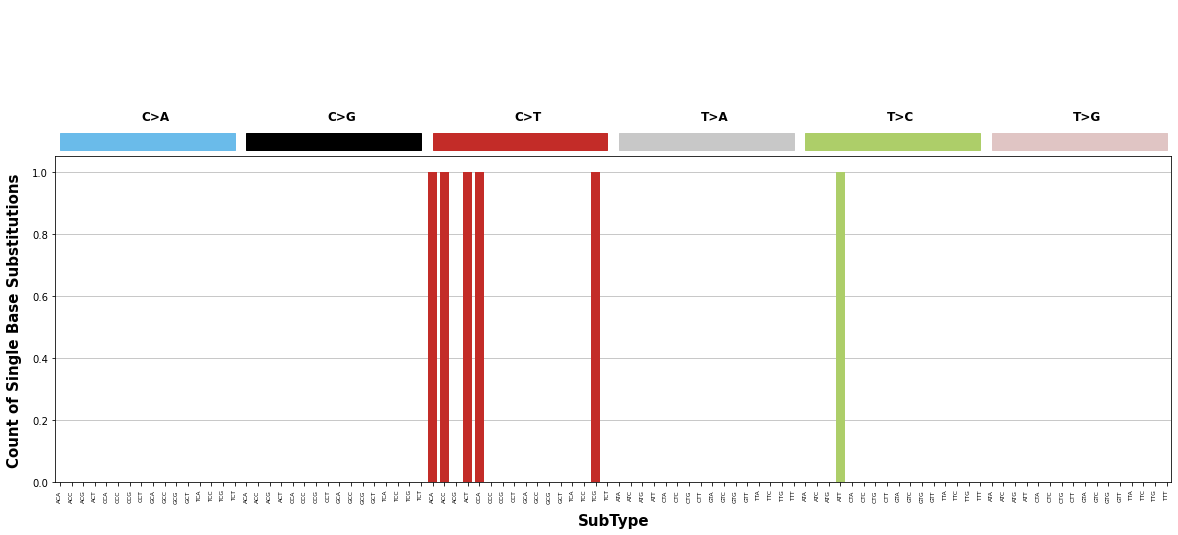

In [417]:
v_purine = sig_table("/Users/davidchen/Desktop/Mutation_signature/V/gisaid_hcov_19_V_snps.vcf", clade= "V", base_type = "purine", aaf_limit=0.01)
sig_plot(v_purine, base_type = "purine")
v_pyrimidine = sig_table("/Users/davidchen/Desktop/Mutation_signature/V/gisaid_hcov_19_V_snps.vcf", clade= "V", base_type = "pyrimidine", aaf_limit=0.01)
sig_plot(v_pyrimidine, base_type = "pyrimidine")

# Clade GH

2 alternate SNPs included out of a total of 478 SNPs
0 identified SNPs do not match reference base!
1 total SNPs sorted into SBS-192 classification scheme
2 alternate SNPs included out of a total of 478 SNPs
0 identified SNPs do not match reference base!
1 total SNPs sorted into SBS-192 classification scheme


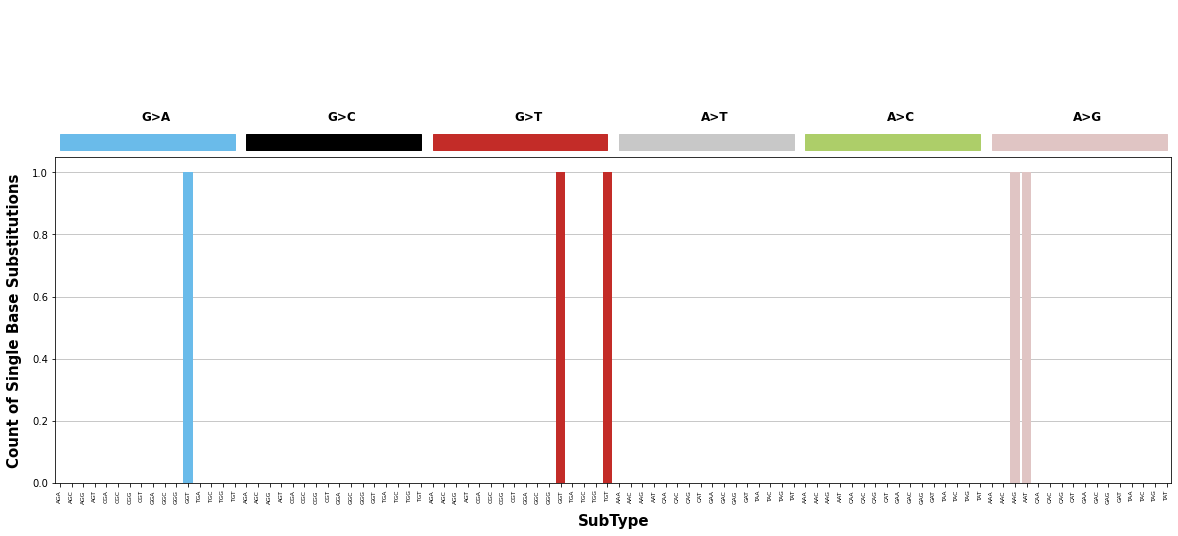

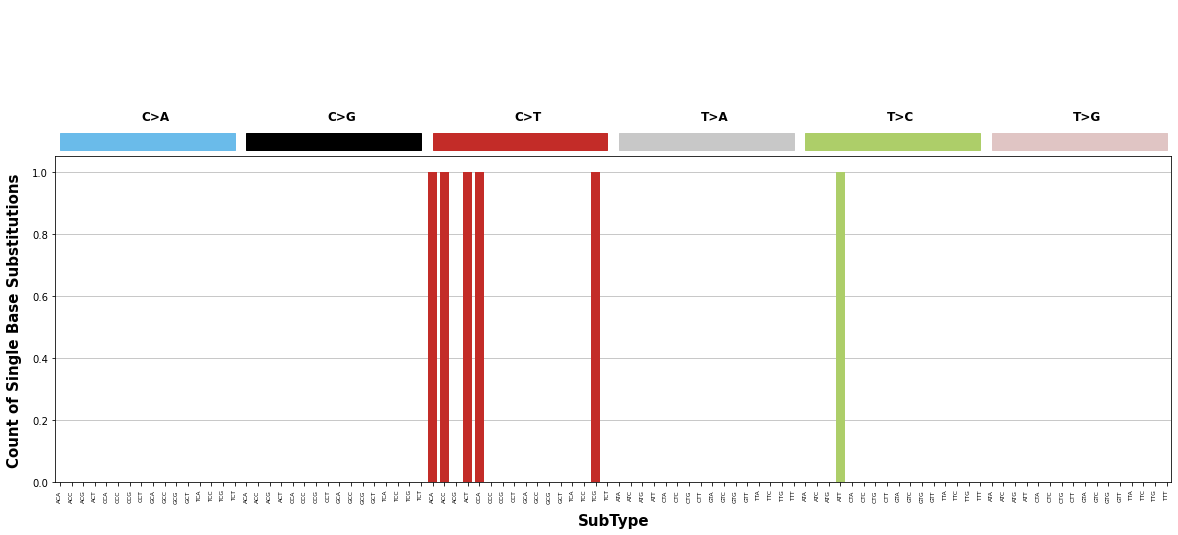

In [418]:
gh_purine = sig_table("/Users/davidchen/Desktop/Mutation_signature/GH/gisaid_hcov_19_GH_snps.vcf", clade= "GH", base_type = "purine", aaf_limit=0.01)
sig_plot(v_purine, base_type = "purine")
gh_pyrimidine = sig_table("/Users/davidchen/Desktop/Mutation_signature/GH/gisaid_hcov_19_GH_snps.vcf", clade= "GH", base_type = "pyrimidine", aaf_limit=0.01)
sig_plot(v_pyrimidine, base_type = "pyrimidine")

# Clade G

In [419]:
g_purine = sig_table("/Users/davidchen/Desktop/Mutation_signature/G/gisaid_hcov_19_G_snps.vcf", clade= "G", base_type = "purine", aaf_limit=0.01)
sig_plot(v_purine, base_type = "purine")
g_pyrimidine = sig_table("/Users/davidchen/Desktop/Mutation_signature/G/gisaid_hcov_19_G_snps.vcf", clade= "G", base_type = "pyrimidine", aaf_limit=0.01)
sig_plot(v_pyrimidine, base_type = "pyrimidine")

0 alternate SNPs included out of a total of 559 SNPs
0 identified SNPs do not match reference base!


AttributeError: Can only use .str accessor with string values!

# Metadata
    

In [4]:
metadata = pd.read_csv('/Users/davidchen/Desktop/Mutation_signature/GISAID_metadata.tsv', sep='\t', header=0)

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
metadata.columns

Index(['strain', 'virus', 'gisaid_epi_isl', 'genbank_accession', 'date', 'region', 'country', 'division', 'location', 'region_exposure', 'country_exposure', 'division_exposure', 'segment', 'length', 'host', 'age', 'sex', 'pangolin_lineage', 'GISAID_clade', 'originating_lab', 'submitting_lab', 'authors', 'url', 'title', 'paper_url', 'date_submitted'], dtype='object')

In [6]:
metadata

,strain,virus,gisaid_epi_isl,genbank_accession,date,region,country,division,location,region_exposure,country_exposure,division_exposure,segment,length,host,age,sex,pangolin_lineage,GISAID_clade,originating_lab,submitting_lab,authors,url,title,paper_url,date_submitted
0,Algeria/G0638_2264/2020,ncov,EPI_ISL_418241,?,2020-03-02,Africa,Algeria,Boufarik,NaN,Africa,Algeria,Boufarik,genome,29730,Human,28,Female,B.1,GH,NIC Viral Respiratory Unit - Institut Pasteur ...,National Reference Center for Viruses of Respi...,Mélanie Albert et al,https://www.gisaid.org,?,?,2020-03-29
1,Algeria/G0640_2265/2020,ncov,EPI_ISL_418242,?,2020-03-08,Africa,Algeria,Blida,NaN,Africa,Algeria,Blida,genome,29846,Human,87,Male,B.1,GH,NIC Viral Respiratory Unit - Institut Pasteur ...,National Reference Center for Viruses of Respi...,Mélanie Albert et al,https://www.gisaid.org,?,?,2020-03-29
2,Algeria/G0860_2262/2020,ncov,EPI_ISL_420037,?,2020-03-02,Africa,Algeria,Boufarik,NaN,Africa,Algeria,Boufarik,genome,29822,Human,41,Male,B.1,GH,NIC Viral Respiratory Unit - Institut Pasteur ...,National Reference Center for Viruses of Respi...,Mélanie Albert et al,https://www.gisaid.org,?,?,2020-04-04
3,Andorra/202552/2020,ncov,EPI_ISL_539496,?,2020-03-13,Europe,Andorra,Andorra,NaN,Europe,Andorra,Andorra,genome,29882,Human,0,Female,B.1.5,O,Hospital Nostra Senyora de Meritxell,Instituto de Salud Carlos III,Iglesias-Caballero et al,https://www.gisaid.org,?,?,2020-09-18
4,Anhui/SZ005/2020,ncov,EPI_ISL_413485,?,2020-01-24,Asia,China,Anhui,Suzhou,Asia,China,Anhui,genome,29860,Human,58,Male,A,O,"Department of microbiology laboratory,Anhui Pr...","Department of microbiology laboratory,Anhui Pr...",Weiwei Li et al,https://www.gisaid.org,?,?,2020-03-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139063,tiger/USA/NY-2-040420/2020,ncov,EPI_ISL_566039,?,2020-04-04,North America,USA,New York,NaN,North America,USA,New York,genome,29872,Panthera tigris jacksoni,?,?,B.1,GH,"Wildlife Conservation Society, Bronx Zoo","Diagnostic Virology Laboratory, United States ...",McAloose et al,https://www.gisaid.org,?,?,2020-07-02
139064,tiger/USA/NY-3-040420/2020,ncov,EPI_ISL_566041,?,2020-04-04,North America,USA,New York,NaN,North America,USA,New York,genome,29863,Panthera tigris jacksoni,?,?,B.1,GH,"Wildlife Conservation Society, Bronx Zoo","Diagnostic Virology Laboratory, United States ...",McAloose et al,https://www.gisaid.org,?,?,2020-07-02
139065,tiger/USA/NY-4-040420/2020,ncov,EPI_ISL_566042,?,2020-04-04,North America,USA,New York,NaN,North America,USA,New York,genome,29834,Panthera tigris jacksoni,?,?,B.1,GH,"Wildlife Conservation Society, Bronx Zoo","Diagnostic Virology Laboratory, United States ...",McAloose et al,https://www.gisaid.org,?,?,2020-07-02
139066,tiger/USA/NY-P3/2020,ncov,EPI_ISL_566040,?,2020-04-04,North America,USA,New York,NaN,North America,USA,New York,genome,29882,Panthera tigris jacksoni,?,?,B.1,GH,"Wildlife Conservation Society, Bronx Zoo","Diagnostic Virology Laboratory, United States ...",McAloose et al,https://www.gisaid.org,?,?,2020-07-02


In [7]:
def meta_search(clade, month, year):
    date = []
    for i in range(1,32):
        if len(str(i)) < 2:
            date.append('2020-'+ str(month) + '-0' + str(i))
        else:
            date.append('2020-' + str(month) + '-' + str(i))
            
    meta_slice = metadata.loc[metadata['date_submitted'].isin(date)]
    meta_slice = meta_slice[meta_slice['GISAID_clade'] == clade]
    
    return meta_slice

In [8]:
def fasta_output(clade, month, year, input_path, output_path):
    
    foo = meta_search(clade = clade, month = month, year = year).reset_index()
    
    accession_list = []
    for row in range(len(foo)):
        strain = foo.loc[row, "strain"]
        gisaid = foo.loc[row, "gisaid_epi_isl"]
        date = foo.loc[row, "date"]
        accession = "hCoV-19/" + str(strain) + '|' + str(gisaid) + '|' + str(date)
        accession_list.append(accession)
        
    fin = open(input_path, 'r')
    fout = open(output_path, 'w+')

    counter=0
    for record in SeqIO.parse(fin,'fasta'):
        for item in accession_list:
            if item == str(record.id):
                fout.write(">" + record.id + "\n")
                fout.write(str(record.seq) + "\n")
                counter+=1
        
    fin.close()
    fout.close()
    
    print("Search Parameters:" )
    print("Clade = " + str(clade))
    print("Month = " + str(month))
    print("Year = " + str(year))
          
    print(str(counter) + " sequences identified and written to output fasta!")

In [24]:
fasta_output(
clade = "V", 
month = "03", 
year = "2020", 
input_path = '/Users/davidchen/Desktop/Mutation_signature/V/gisaid_hcov-19_V.fasta', 
output_path = '/Users/davidchen/Desktop/Mutation_signature/V/test.fasta'
)

Search Parameters:
Clade = V
Month = 03
Year = 2020
169 sequences identified and written to output fasta!


In [29]:
for clade in ["L", "O", "V", "S", "GH", "GR", "G"]:
    input_path = '/Users/davidchen/Desktop/Mutation_signature/' + str(clade) + '/gisaid_hcov_19_' + str(clade) + '.fasta'
    for month in ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]:
        for year in ["2020"]:
            fasta_output(clade = clade,
                         month = month,
                         year = year,
                         input_path = input_path,
                         output_path = '/Users/davidchen/Desktop/Mutation_signature/' + str(clade) + '/' + str(clade) + '_' + str(month) + '_' + str(year) + '.fasta')
            

Search Parameters:
Clade = O
Month = 01
Year = 2020
6 sequences identified and written to output fasta!
Search Parameters:
Clade = O
Month = 02
Year = 2020
22 sequences identified and written to output fasta!
Search Parameters:
Clade = O
Month = 03
Year = 2020
232 sequences identified and written to output fasta!
Search Parameters:
Clade = O
Month = 04
Year = 2020
372 sequences identified and written to output fasta!
Search Parameters:
Clade = O
Month = 05
Year = 2020
604 sequences identified and written to output fasta!
Search Parameters:
Clade = O
Month = 06
Year = 2020
568 sequences identified and written to output fasta!
Search Parameters:
Clade = O
Month = 07
Year = 2020
435 sequences identified and written to output fasta!
Search Parameters:
Clade = O
Month = 08
Year = 2020
329 sequences identified and written to output fasta!
Search Parameters:
Clade = O
Month = 09
Year = 2020
195 sequences identified and written to output fasta!
Search Parameters:
Clade = O
Month = 10
Year = 20